In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [12]:
gender_submission = pd.read_csv('Titanic/gender_submission.csv')
train = pd.read_csv('Titanic/train.csv', dtype={'Survived':int, 
                                                'Pclass':str, 
                                                'Sex':str, 
                                                'Age':float,
                                                'Sib Sp':int, 
                                                'Parch':int, 
                                                'Ticket':str, 
                                                'Fare':float, 
                                                'Cabin':str,
                                                'Embarked':str})

test = pd.read_csv('Titanic/test.csv', dtype={'Pclass':str, 
                                                'Sex':str, 
                                                'Age':float,
                                                'Sib Sp':int, 
                                                'Parch':int, 
                                                'Ticket':str, 
                                                'Fare':float, 
                                                'Cabin':str,
                                                'Embarked':str}) 
                                               

train = train[train.columns[1:]] # removing column 'id'
test = test[test.columns[1:]]    # removing column 'id'

In [3]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Number of Categories

In [4]:
def nan_cat(df):
    df = df.copy()
    des = df.describe()
    cat = [i for i in df.columns if i not in des.columns]
    for c in cat:
        df[c].replace(df[c].dropna().unique(), range(df[c].nunique()), inplace=True)

    des = des.T 
    des['%missing'] = df.isnull().sum()/len(df) * 100
    des['n_cat'] = df.nunique()
    
    fig, ax = plt.subplots(figsize=(13, 6))
    plt.style.use('fivethirtyeight')
    sns.barplot(
        data=des.sort_values('%missing', ascending=False), 
        x='%missing', 
        y=des.sort_values('%missing', ascending=False).index, 
        color='lightblue').set(title='%missing'.title())
    
    sns.despine()
    plt.xlabel(' ')
    plt.show()

    fig, ax = plt.subplots(figsize=(13, 6))
    plt.style.use('fivethirtyeight')
    sns.barplot(
        data=des.sort_values('n_cat', ascending=False), 
        x='n_cat',
        y=des.sort_values('n_cat', ascending=False).index, 
        color='orange').set(title='number of categories'.title())
    
    sns.despine()
    plt.xlabel(' ')
    plt.show()

# Missing Values and Number of Categories

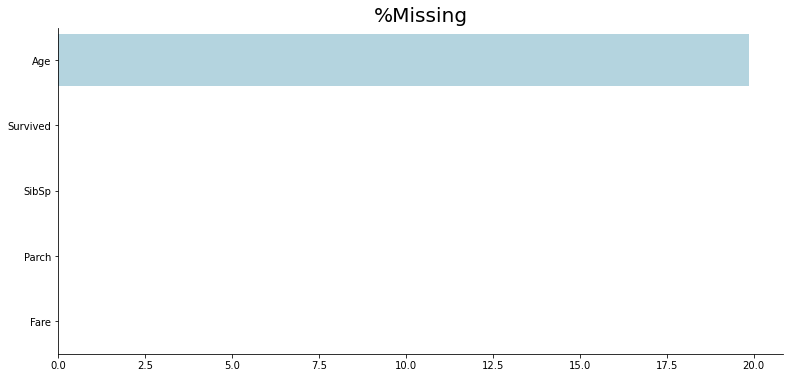

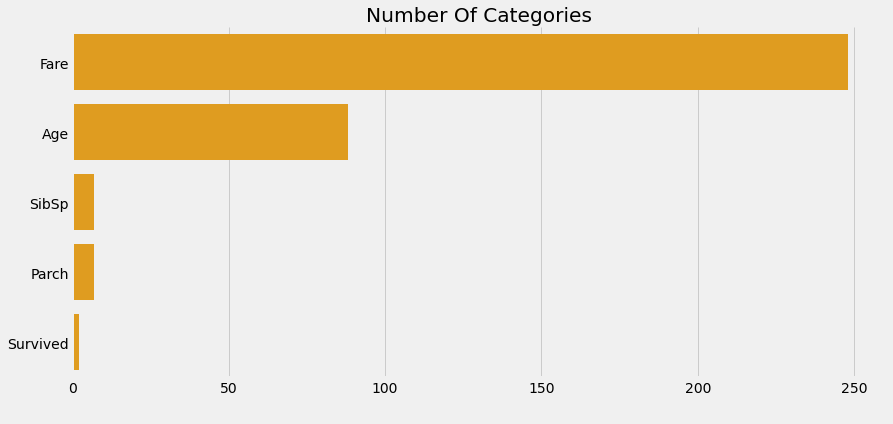

In [5]:
nan_cat(train)

In [6]:
from DimensionalityReduction import DimensionalityReduction
dr = DimensionalityReduction()
dr.fit(train, 'Survived')

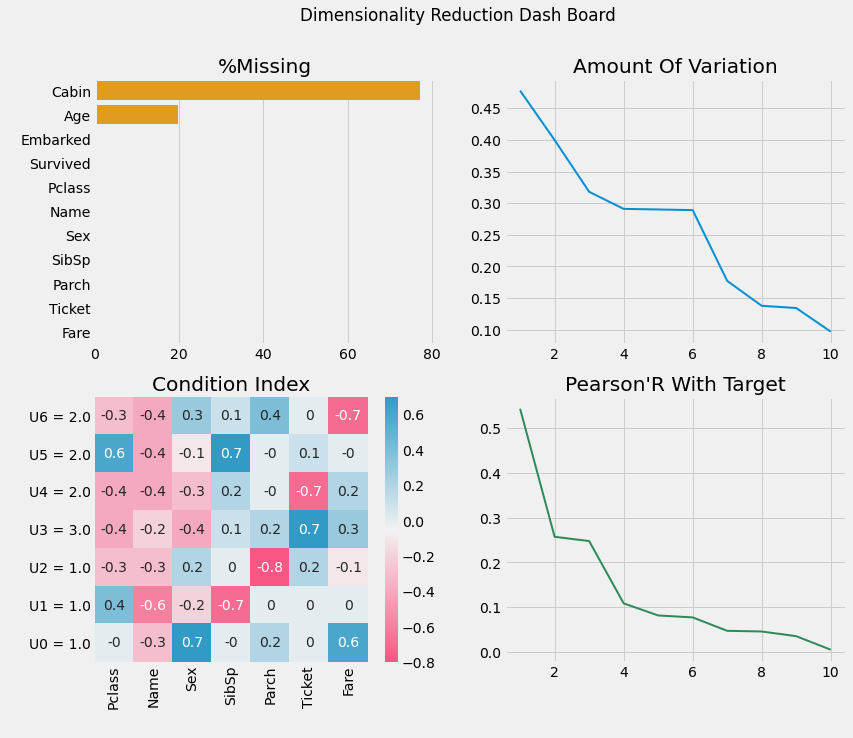

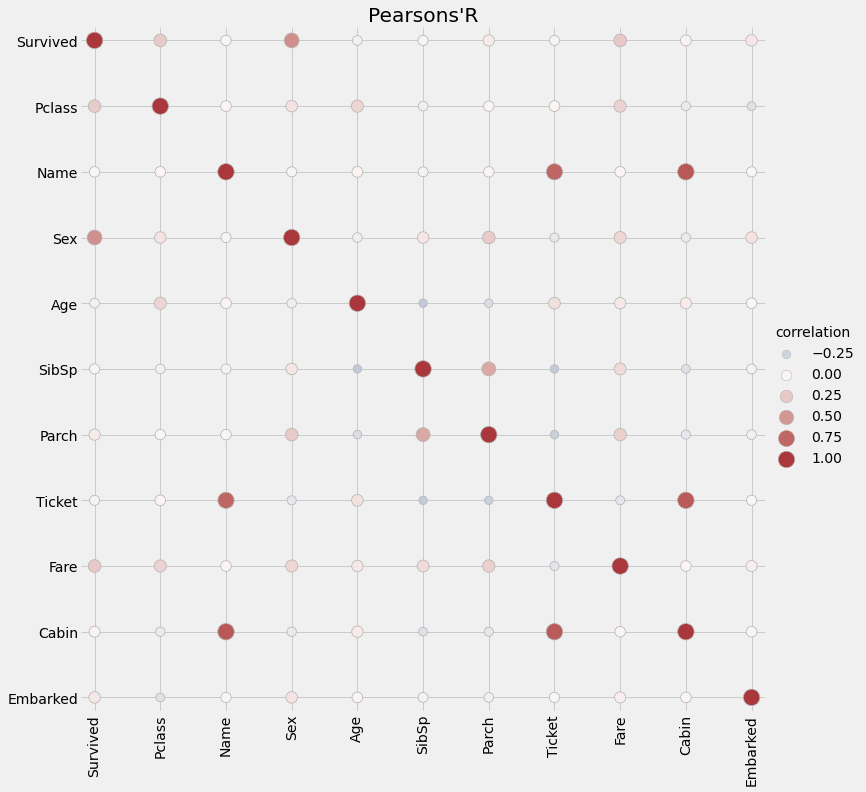

In [7]:
dr.plot()

In [8]:
dr.VIF

,VIF
Name,18.568388
Cabin,17.533965
Ticket,14.446655
Pclass,5.719799
Age,4.838303
Fare,3.109065
Sex,1.999642
Parch,1.787258
Embarked,1.760054
SibSp,1.759614


In [9]:
pct_unique_cat_ticket = len(train['Ticket'].unique())/len(train['Ticket']) * 100
print(f'%UniqueCategories of feature "Ticket": {round(pct_unique_cat_ticket, 4)}%')

%UniqueCategories of feature "Ticket": 76.431%


1) 'Cabin' has almost 80% of missing values in both dataframe --> drop feature

2) 'Age' has around 20% of missing values in both dataframe --> impute

3) 'Embarked' and 'Fare' has insignificant amount of missing values in trainset and testset respectively --> drop row

4) There are too many categories in feature 'Ticket'. 'Ticket' would not be helpful to improve our model. Let's try to extract info from the ticket numbers instead.

In [10]:
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

In [35]:
train['Ticket'].iloc[865].split(' ')[0].replace('2','')

'3685'

In [41]:
def ticket_letter(row):
    for i in [0,1,2,3,4,5,6,7,8,9, '/', '.']:
        row = row.replace(str(i),'')
    if row == '':
        return None
    return row

train['Ticket'] = train['Ticket'].apply(ticket_letter)

In [46]:
train['Ticket']

0          A 
1         PC 
2      STONO 
3        None
4        None
        ...  
886      None
887      None
888       WC 
889      None
890      None
Name: Ticket, Length: 891, dtype: object

In [42]:
train['Ticket'].value_counts()

PC             60
CA             41
A              28
SOTONOQ        15
STONO          12
WC             10
SCPARIS         7
STONO           6
SOC             6
FCC             5
C               5
LINE            4
SCParis         4
SOPP            3
WEP             3
PP              3
SCAH            2
SOTONO          2
SWPP            2
PPP             2
SCAH Basle      1
SP              1
FC              1
Fa              1
CASOTON         1
SOP             1
SCOW            1
SCA             1
SC              1
AS              1
Name: Ticket, dtype: int64

In [50]:
def ticket_letter2(row):
    if row not in ['PC ','CA ','A ','SOTONOQ ','STONO  ','WC ']:
        row = 'rare'
    
    return row

train['Ticket'] = train['Ticket'].apply(ticket_letter2)

<AxesSubplot:>

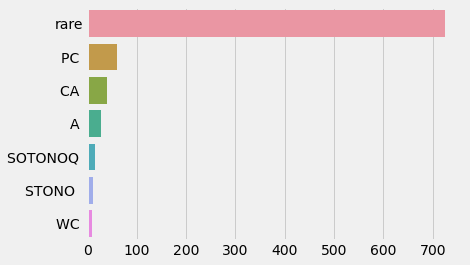

In [52]:
sns.barplot(y=train['Ticket'].value_counts().index, x=train['Ticket'].value_counts().values)

In [53]:
from WordCountinColumn import word_count_in_col
wcc = word_count_in_col()
wcc.fit(train['Name'])
res = pd.DataFrame(wcc.res, index=['freq']).T
res.sort_values('freq', ascending=False, inplace=True)
res.head(10)

,freq
Mr.,517
Miss.,182
Mrs.,125
William,63
John,44
Master.,40
Henry,33
James,24
George,23
Charles,23


In [54]:
def title(row):
    if 'Mr.' in row.split():
        return 'Mr.'
    elif 'Miss.' in row.split():
        return 'Miss.'
    elif 'Mrs.' in row.split():
        return 'Mrs.'
    elif 'Master.' in row.split():
        return 'Master.'
    else:
        return 'other'
    
train['title'] = train['Name'].apply(title)
train.drop('Name', axis=1, inplace=True)
test['title'] = test['Name'].apply(title)
test.drop('Name', axis=1, inplace=True)

# EDA 

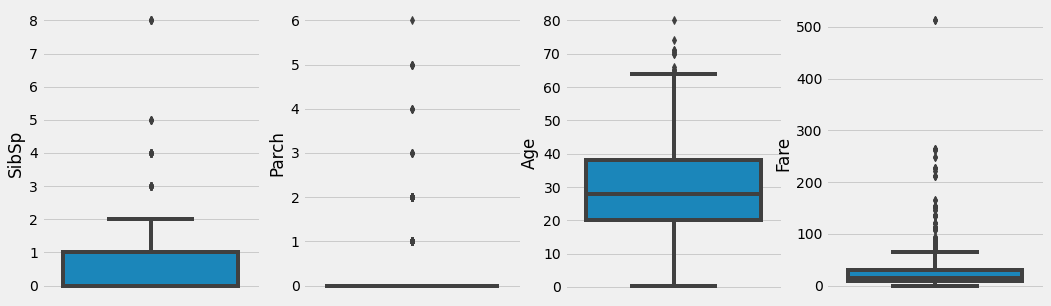

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
ax = ax.flatten()
sns.boxplot(data=train, y='SibSp', ax=ax[0])
sns.boxplot(data=train, y='Parch', ax=ax[1])
sns.boxplot(data=train, y='Age', ax=ax[2])
sns.boxplot(data=train, y='Fare', ax=ax[3])
plt.show()

'SibSp', 'Parch', 'Age', 'Fare' contain outliers.

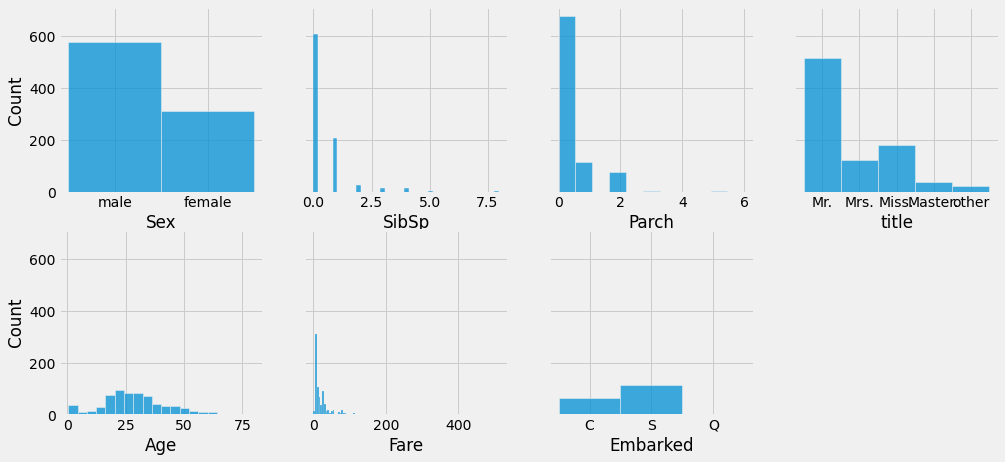

In [56]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7), sharey=True)
ax = ax.flatten()
sns.histplot(data=train, x='Sex', ax=ax[0])
sns.histplot(data=train, x='SibSp', ax=ax[1])
sns.histplot(data=train, x='Parch', ax=ax[2])
sns.histplot(data=train, x='title', ax=ax[3])
sns.histplot(data=train, x='Age', ax=ax[4])
sns.histplot(data=train, x='Fare', ax=ax[5])
sns.histplot(data=train.dropna().astype(str), x='Embarked', ax=ax[6])
fig.delaxes(ax[7])
plt.show()

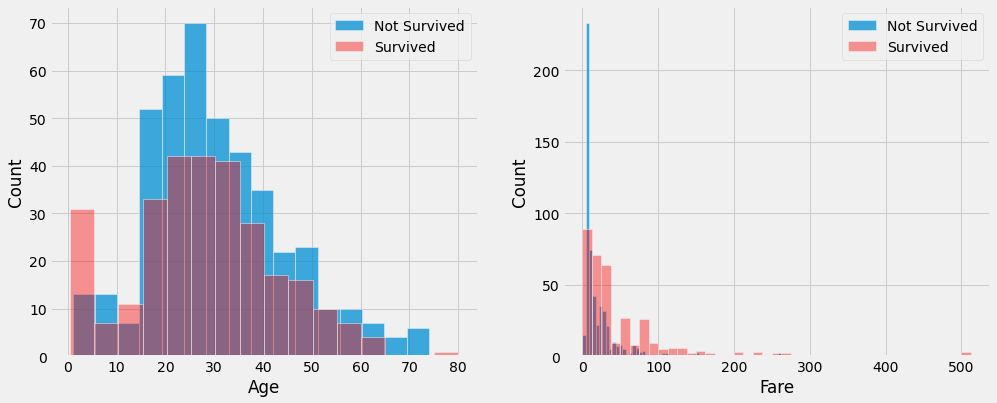

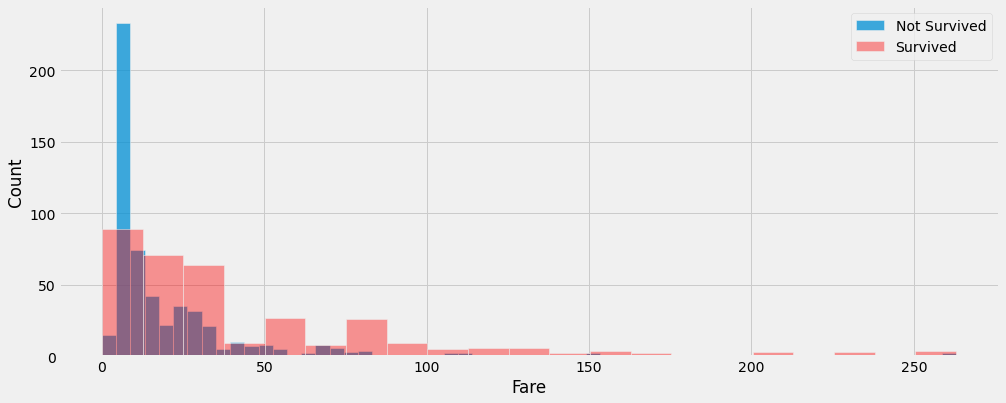

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = ax.flatten()
sns.histplot(train[train['Survived'] == 0]['Age'], ax=ax[0])
sns.histplot(train[train['Survived'] == 1]['Age'], color='red', alpha=0.4, ax=ax[0])
sns.histplot(train[train['Survived'] == 0]['Fare'], ax=ax[1])
sns.histplot(train[train['Survived'] == 1]['Fare'], color='red', alpha=0.4, ax=ax[1])
ax[0].legend(['Not Survived', 'Survived'])
ax[1].legend(['Not Survived', 'Survived'])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.histplot(train[(train['Survived'] == 0) & (train['Fare'] <= 300)]['Fare'])
sns.histplot(train[(train['Survived'] == 1) & (train['Fare'] <= 300)]['Fare'], color='red', alpha=0.4)
plt.legend(['Not Survived', 'Survived'])
plt.show()

In [58]:
for df in [train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
def alone(row):
    if row == 1:
        return 1
    else:
        return 0
    
train['IsAlone'] = train['FamilySize'].apply(alone)
test['IsAlone'] = test['FamilySize'].apply(alone)

<AxesSubplot:>

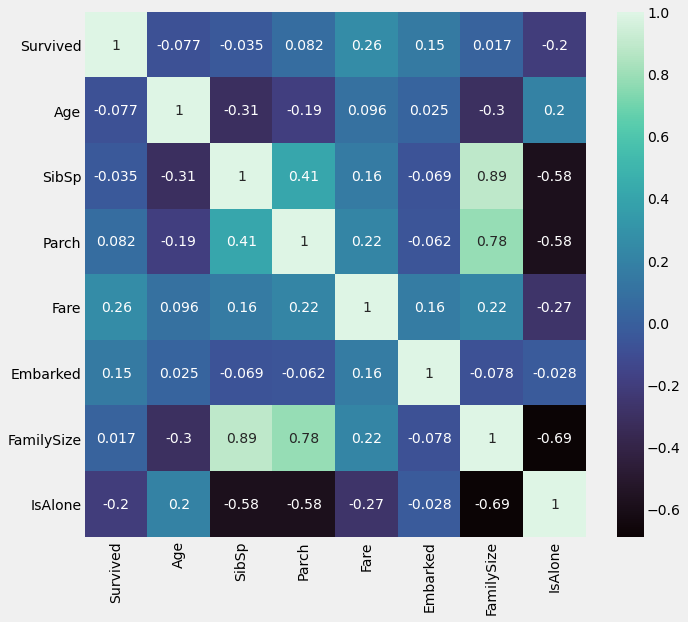

In [59]:
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(train.replace({'S':0, 'C':1, 'Q':1}).corr(), annot=True, cmap='mako')

# Split the dataset

In [60]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)

In [61]:
train['Age'] = train['Age'].fillna(train.groupby('SibSp')['Age'].transform('median'))
train['Age'] = train['Age'].fillna(train.groupby('Parch')['Age'].transform('median'))

val['Age'] = val['Age'].fillna(val.groupby('SibSp')['Age'].transform('median'))
val['Age'] = val['Age'].fillna(val.groupby('Parch')['Age'].transform('median'))

test['Age'] = test['Age'].fillna(test.groupby('SibSp')['Age'].transform('median'))
test['Age'] = test['Age'].fillna(test.groupby('Parch')['Age'].transform('median'))

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [62]:
Embarked_mode = train.groupby(list(train.columns)).apply(lambda x: x.mode())[['Embarked']].mode().values[0][0]
print(f'The mode of feature "Embarked" groupped by "Sex": {Embarked_mode}')

train['Embarked'].fillna(Embarked_mode, inplace=True)

The mode of feature "Embarked" groupped by "Sex": S


C:\Users\Hindy\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:4439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [63]:
test['Fare'] = test['Fare'].fillna(test.groupby('IsAlone')['Fare'].transform('median'))

In [64]:
def bin_age(row):
    if row < 16:
        return '<16'
    if row >= 16:
        if row < 30:
            return '16-30'
    if row >= 30:
        if row < 40:
            return '30-40'
    if row >= 40:
        if row < 50:
            return '40-50'
    if row >= 50:
        return '>50'

train['Age_binned'] = train['Age'].apply(bin_age)
val['Age_binned'] = val['Age'].apply(bin_age)
test['Age_binned'] = test['Age'].apply(bin_age)

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [65]:
def bin_fare(row):
    if row < 40:
        return '<40'
    if row >= 40:
        if row < 110:
            return '40-110'
    if row >= 110:
        return '>110'
    
train['Fare_binned'] = train['Fare'].apply(bin_fare)
val['Fare_binned'] = val['Fare'].apply(bin_fare)
test['Fare_binned'] = test['Fare'].apply(bin_fare)

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [66]:
checkna([train, val, test])

NameError: name 'checkna' is not defined

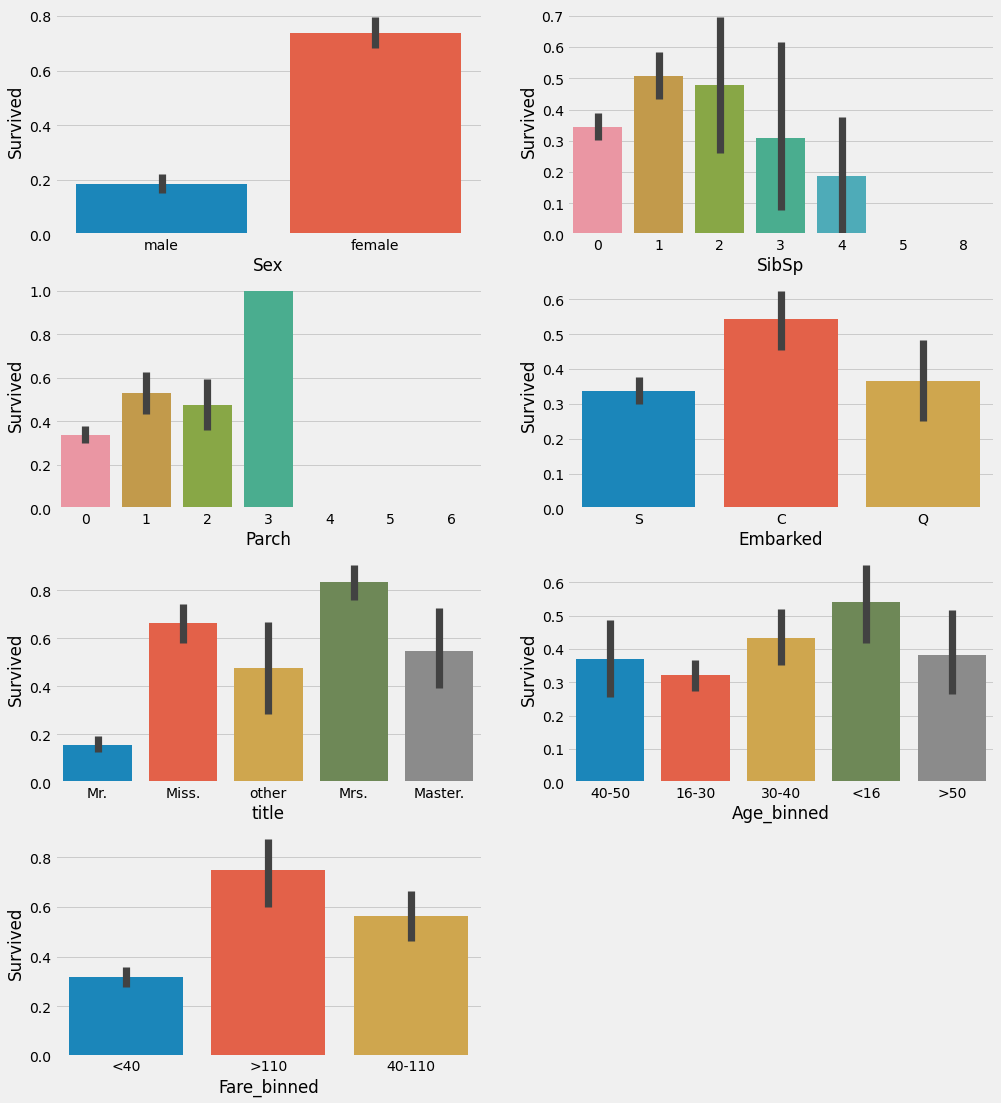

In [67]:
fig, ax = plt.subplots(4, 2, figsize=(15, 18))
ax = ax.flatten()
sns.barplot(data=train, x='Sex', y='Survived', ax=ax[0])
sns.barplot(data=train, x='SibSp', y='Survived', ax=ax[1])
sns.barplot(data=train, x='Parch', y='Survived', ax=ax[2])
sns.barplot(data=train, x='Embarked', y='Survived', ax=ax[3])
sns.barplot(data=train, x='title', y='Survived', ax=ax[4])
sns.barplot(data=train, x='Age_binned', y='Survived', ax=ax[5])
sns.barplot(data=train, x='Fare_binned', y='Survived', ax=ax[6])
fig.delaxes(ax[7])
plt.show()

1) Female have a higher chance of survived

2) chance of survived (Sibsp): 1 > 2 > 0 > 3 > 4 > 5&8

3) chance of survived (Parch): 3 > 1 > 2 > 0 > 5&6

4) chance of survived (Embarked): C > Q > S

5) chance of survived (Title): Mrs. > Miss. > Master. > other > Mr.

6) chance of survived (Age_binned): under 16 has a higher chance of survived

7) chance of survived (Fare_binned): over $110 > 40-100 > under 40 

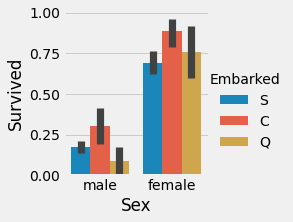

In [68]:
sns.catplot(data=train, x='Sex', y='Survived', hue='Embarked', kind='bar', height=3)

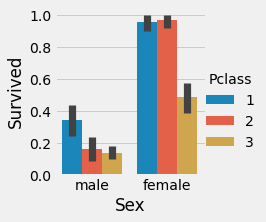

In [69]:
sns.catplot(data=train, x='Sex', y='Survived', hue='Pclass', kind='bar', height=3)

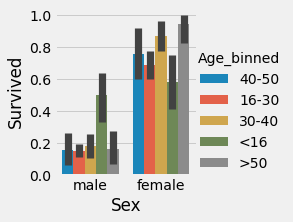

In [70]:
sns.catplot(data=train, x='Sex', y='Survived', hue='Age_binned', kind='bar', height=3)

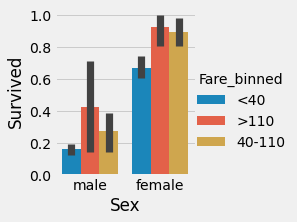

In [71]:
sns.catplot(data=train, x='Sex', y='Survived', hue='Fare_binned', kind='bar', height=3)

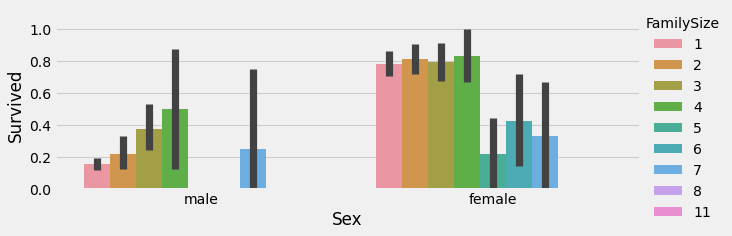

In [72]:
sns.catplot(data=train, x='Sex', y='Survived', hue='FamilySize', kind='bar', height=3, aspect=3)

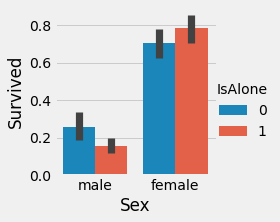

In [73]:
sns.catplot(data=train, x='Sex', y='Survived', hue='IsAlone', kind='bar', height=3)

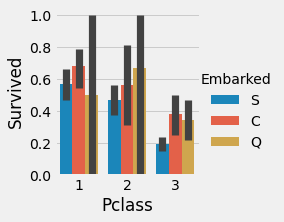

In [74]:
sns.catplot(data=train, x='Pclass', y='Survived', hue='Embarked', kind='bar', height=3)

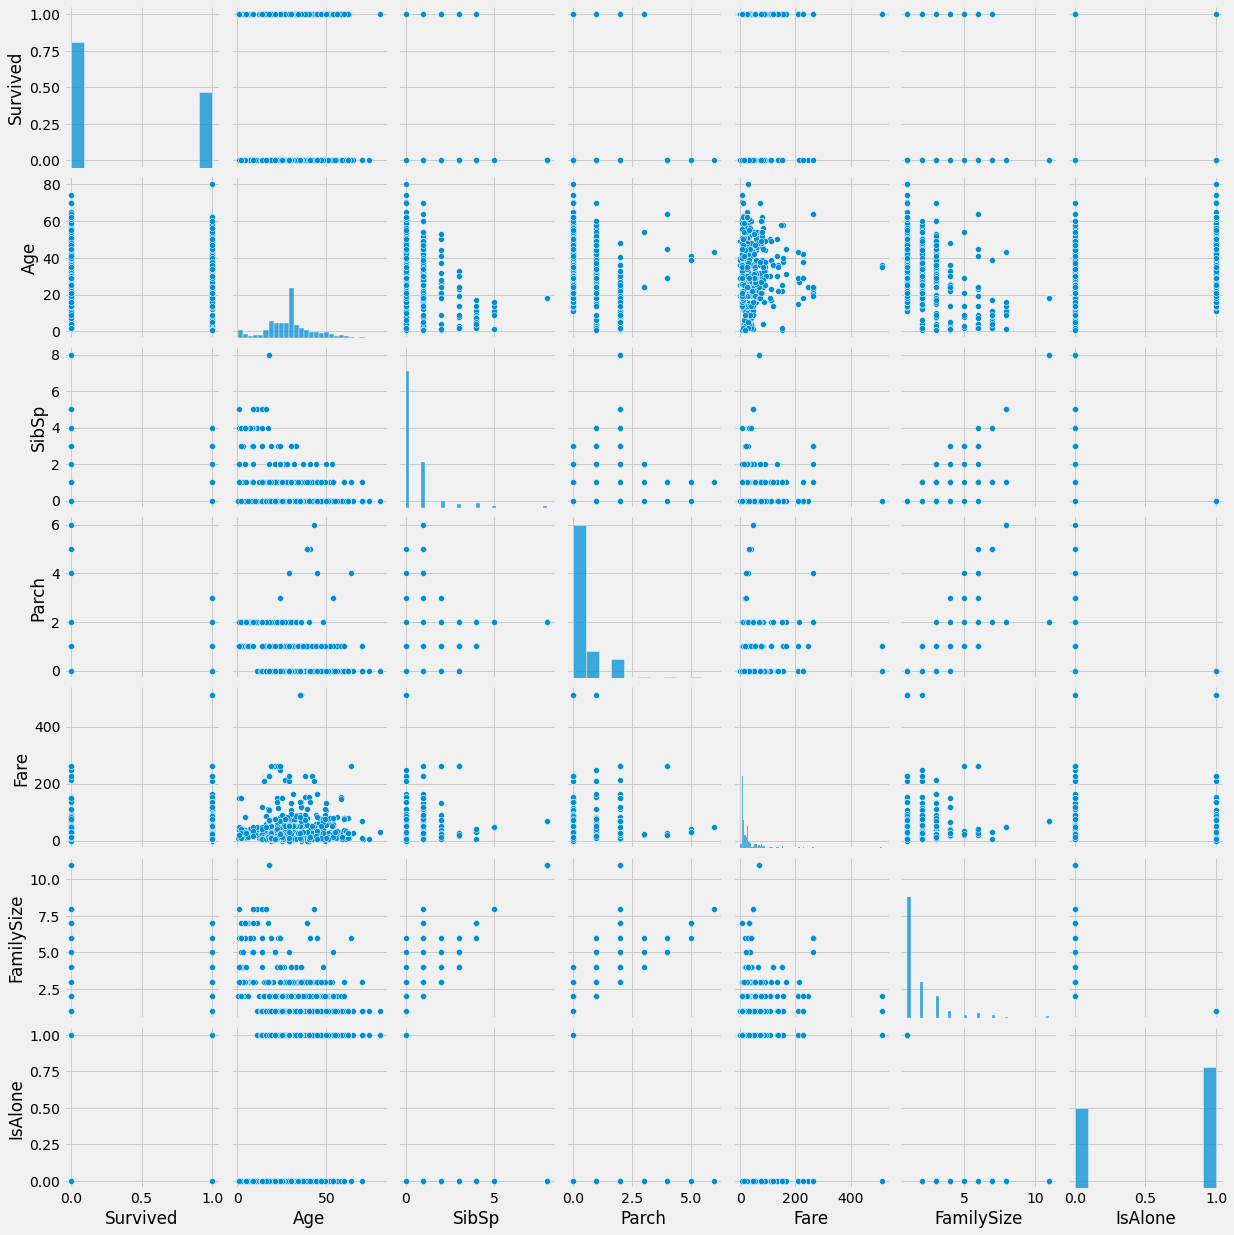

In [75]:
sns.pairplot(train, palette='set2')

# Feature Engineering

In [76]:
for df in [train, val, test]:
    df['Sex_Pclass'] = df['Sex'] + df['Pclass']
    df['Sex_Embarked'] = df['Sex'] + df['Embarked']
    df['Sex_title'] = df['Sex'] + df['title']
    df['Sex_Age_binned'] = df['Sex'] + df['Age_binned']
    df['Sex_Fare_binned'] = df['Sex'] + df['Fare_binned']
    df['Sex_IsAlone'] = df['Sex'] + df['IsAlone'].apply(lambda x: str(x))

    df['Pclass_Embarked'] = df['Pclass'] + df['Embarked']
    df['Pclass_title'] = df['Pclass'] + df['title']
    df['Pclass_Age_binned'] = df['Pclass'] + df['Age_binned']
    df['Pclass_Fare_binned'] = df['Pclass'] + df['Fare_binned']
    df['Pclass_IsAlone'] = df['Pclass'] + df['IsAlone'].apply(lambda x: str(x))

    df['Embarked_title'] = df['Embarked'] + df['title']
    df['Embarked_Age_binned'] = df['Embarked'] + df['Age_binned']
    df['Embarked_Fare_binned'] = df['Embarked'] + df['Fare_binned']
    df['Embarked_IsAlone'] = df['Embarked'] + df['IsAlone'].apply(lambda x: str(x))

    df['title_Age_binned'] = df['title'] + df['Age_binned']
    df['title_Fare_binned'] = df['title'] + df['Fare_binned']
    df['title_IsAlone'] = df['title'] + df['IsAlone'].apply(lambda x: str(x))

    df['Age_binned_Fare_binned'] = df['Age_binned'] + df['Fare_binned']
    df['Age_binned_IsAlone'] = df['Age_binned'] + df['IsAlone'].apply(lambda x: str(x))

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
F:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

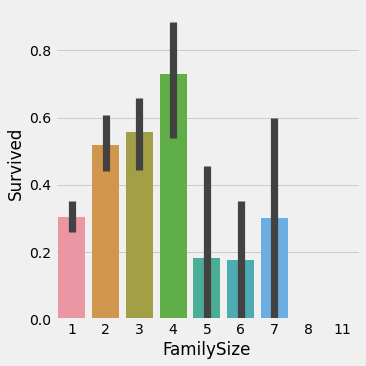

In [77]:
sns.catplot(data=train, x='FamilySize', y='Survived', kind='bar')

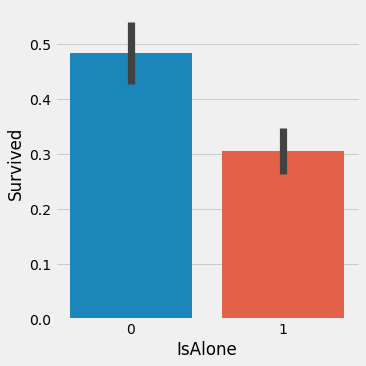

In [78]:
sns.catplot(data=train, x='IsAlone', y='Survived', kind='bar')

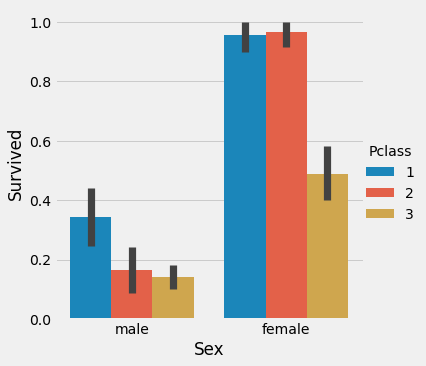

In [79]:
sns.catplot(data=train, x='Sex', y='Survived', hue='Pclass', kind='bar')

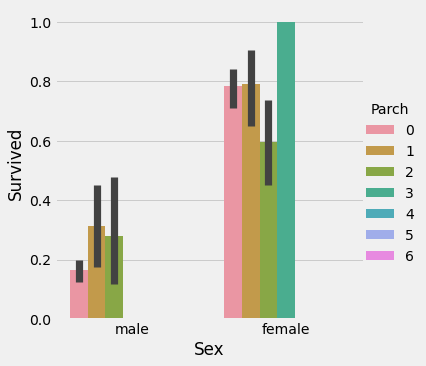

In [80]:
sns.catplot(data=train, x='Sex', y='Survived', hue='Parch', kind='bar')

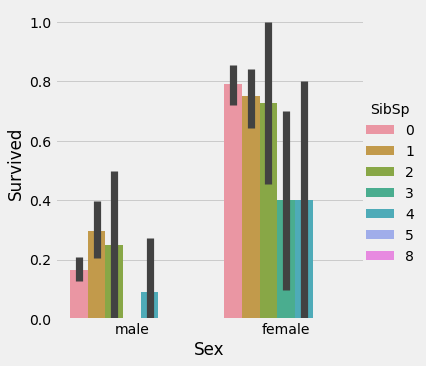

In [81]:
sns.catplot(data=train, x='Sex', y='Survived', hue='SibSp', kind='bar')

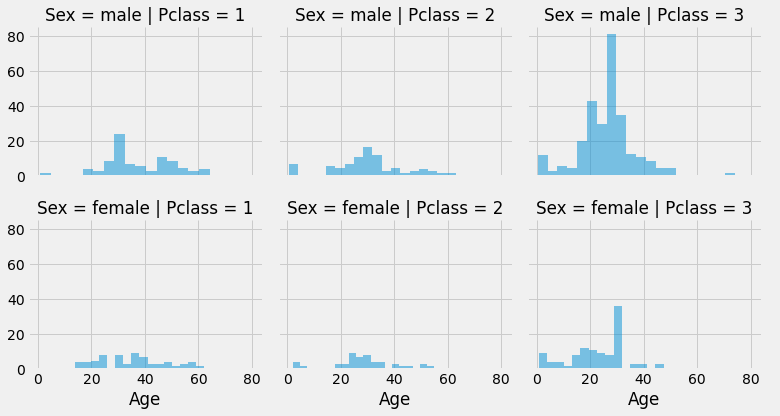

In [82]:
grid = sns.FacetGrid(train, row='Sex', col='Pclass', height=3, aspect=1.2)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

# Label Encoding 

In [83]:
cat = list(train.drop(['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass', 'IsAlone', 'FamilySize'], axis=1).columns)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for df in [train, val, test]:    
    for c in cat:
        df[c] = le.fit_transform(df[c])
    df = df.astype(float)

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [84]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']

X_val = val.drop('Survived', axis=1)
y_val = val['Survived']

# Feature Scaling

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns).astype(float)
X_val = pd.DataFrame(scaler.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

# Naive Modeling 

 
Searching the best subset of features with LogisticRegression...
----------------------------------------------------------Trial 1----------------------------------------------------------
1/32: ['Pclass']
      Accuracy: 0.6727, Standard Deviation: 0.0182
 
2/32: ['Sex']
      Accuracy: 0.7879, Standard Deviation: 0.0293
 
3/32: ['Age']
      Accuracy: 0.6236, Standard Deviation: 0.0028
 
4/32: ['SibSp']
      Accuracy: 0.6236, Standard Deviation: 0.0028
 
5/32: ['Parch']
      Accuracy: 0.6152, Standard Deviation: 0.0076
 
6/32: ['Fare']
      Accuracy: 0.6699, Standard Deviation: 0.0219
 
7/32: ['Embarked']
      Accuracy: 0.6391, Standard Deviation: 0.028
 
8/32: ['title']
      Accuracy: 0.6236, Standard Deviation: 0.0028
 
9/32: ['FamilySize']
      Accuracy: 0.6236, Standard Deviation: 0.0028
 
10/32: ['IsAlone']
      Accuracy: 0.6081, Standard Deviation: 0.0295
 
11/32: ['Age_binned']
      Accuracy: 0.6137, Standard Deviation: 0.0183
 
12/32: ['Fare_binned']
      Accuracy:

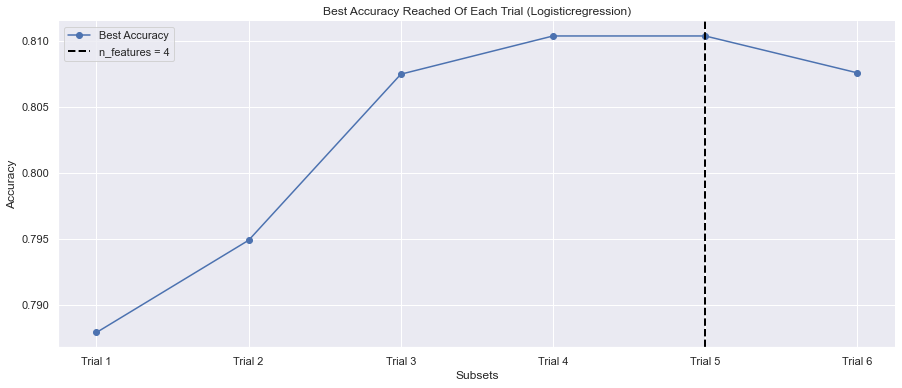

--------------------------------End of Recursive Features Selection (LogisticRegression)-------------------------------


In [99]:
from RecursiveFeatureSelector import RecursiveFeatureSelector
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
rfs = RecursiveFeatureSelector()
rfs.search(estimators=lr, 
           X=X_train.astype(float), 
           y=y_train, 
           cv=5, 
           scoring='accuracy', 
           max_trial=None, 
           tolerance=1, 
           least_gain=None,
           prior=None,
           exclusions=None,
           n_digit=4, 
           verbose=4)

### Best subset for lr ['Sex', 'FamilySize', 'Pclass_IsAlone', 'Fare']

In [43]:
from sklearn.model_selection import GridSearchCV

def hyperParameterTuning(model, X_train, y_train, search_space):
    gs = GridSearchCV(estimator=model,
                           param_grid=search_space,
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gs.fit(X_train,y_train)
    
    for k, v in gs.best_params_.items():
        if type(v) == str:
            print(f"{k}='{v}',")
        if type(v) != str:    
            print(f"{k}={v},") 

In [602]:
search_space_lr={'penalty':['l1', 'l2', 'elasticnet', 'None'], 
              'dual':[True, False], 
              'tol':[1, 0.1, 0.001, 0.0001, 0.00001], 
              'C':[1, 0.1, 0.001, 0.0001, 0.00001], 
              'fit_intercept':[True, False], 
              'intercept_scaling':[1], 
              'class_weight':['balanced'], 
              'random_state':[0], 
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
              'max_iter':[1000], 
              'multi_class':['auto'], 
              'verbose':[0], 
              'warm_start':[False], 
              'n_jobs':[4], 
              'l1_ratio':[1, 0.1, 0.001, 0.0001, 0.00001]}
    
hyperParameterTuning(lr, X_train[rfs.best_subsets['LogisticRegression']], y_train, search_space_lr)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
C=0.001,
class_weight='balanced',
dual=False,
fit_intercept=True,
intercept_scaling=1,
l1_ratio=0.1,
max_iter=1000,
multi_class='auto',
n_jobs=4,
penalty='elasticnet',
random_state=0,
solver='saga',
tol=0.1,
verbose=0,
warm_start=False,


F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  category=UserWarning


In [143]:
lr = LogisticRegression(C=0.001,
class_weight='balanced',
dual=False,
fit_intercept=True,
intercept_scaling=1,
l1_ratio=0.1,
max_iter=1000,
multi_class='auto',
n_jobs=4,
penalty='elasticnet',
random_state=0,
solver='saga',
tol=0.1,
verbose=0,
warm_start=False)

In [44]:
from sklearn.metrics import classification_report

def plot_cr(model, X_val, y_val, target_names):
    y_pred = model.predict(X_val)
    y_true = y_val

    cr = classification_report(y_true, y_pred)
    cols=cr.split()[:3]
    score=cr.split()[5:8]
    score2=cr.split()[10:13]
    metric=cr.split()[14:15]

    fig, ax = plt.subplots(figsize=(5, 3))
    sns.heatmap(pd.DataFrame([score, score2], index=target_names, columns=cols).astype(float), annot=True, cmap='coolwarm')
    plt.title('Classification Report')
    plt.show()

    print(f'Cross Validated Accuracy: {cr.split()[15]}')

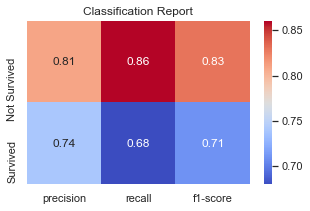

Cross Validated Accuracy: 0.79


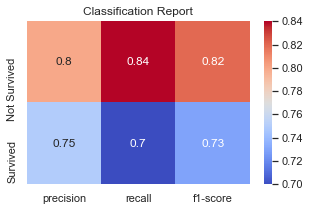

Cross Validated Accuracy: 0.78


In [177]:
lr.fit(X_train[rfs.best_subsets['LogisticRegression']], y_train)
plot_cr(lr, X_train[rfs.best_subsets['LogisticRegression']], y_train, ['Not Survived', 'Survived'])
plot_cr(lr, X_val[rfs.best_subsets['LogisticRegression']], y_val, ['Not Survived', 'Survived'])

 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Embarked_Age_binned']
 
Best Accuracy: 
     0.8006
 
Total Time Spent: 16.22(s)


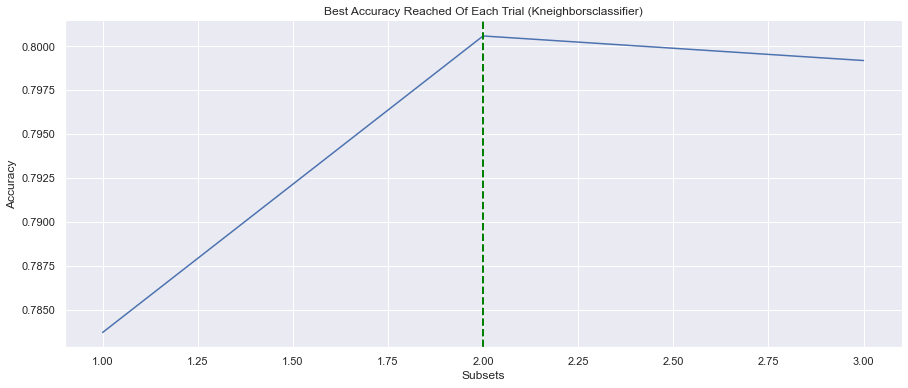

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Embarked_title', 'Pclass_title']
 
Best Accuracy: 
     0.8132
 
Total Time Spent: 11.92(s)


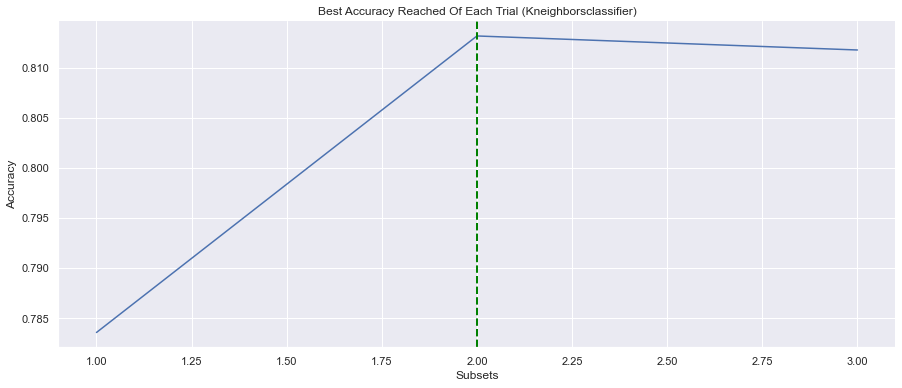

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Embarked', 'Age_binned_Fare_binned', 'Embarked', 'Sex_title']
 
Best Accuracy: 
     0.8258
 
Total Time Spent: 32.39(s)


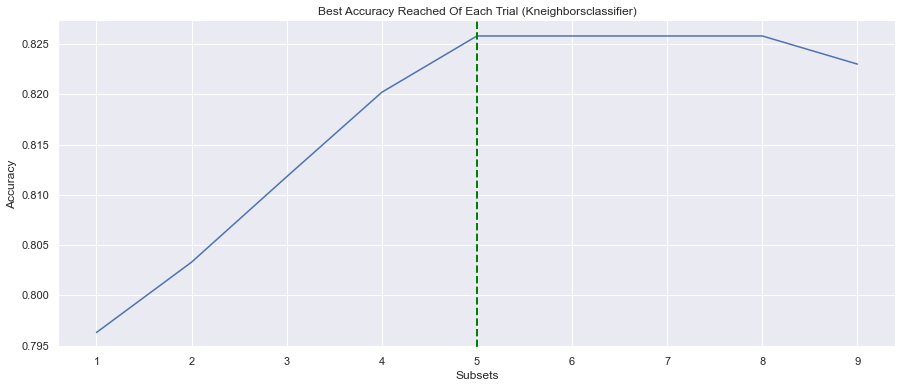

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['title_Fare_binned', 'Pclass_Embarked', 'Sex_Embarked']
 
Best Accuracy: 
     0.8245
 
Total Time Spent: 19.17(s)


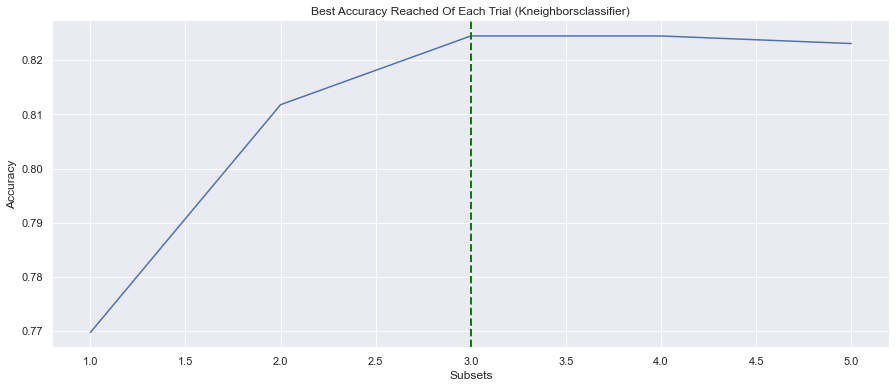

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'SibSp', 'title', 'Sex_Age_binned', 'title_IsAlone', 'Sex_IsAlone']
 
Best Accuracy: 
     0.8385
 
Total Time Spent: 32.28(s)


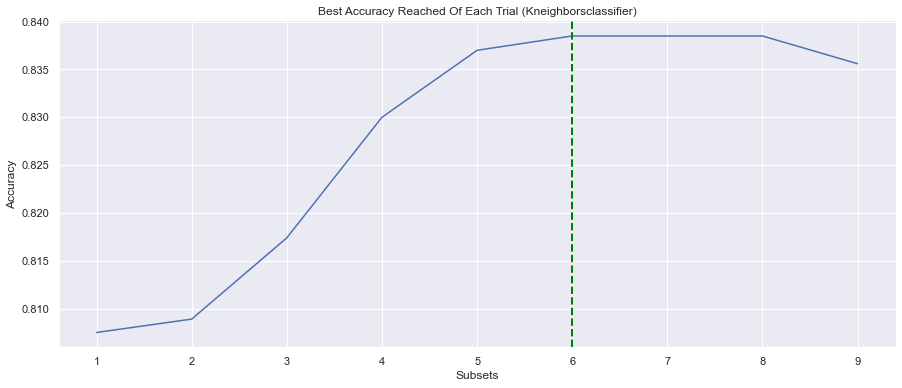

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Pclass', 'Embarked', 'Pclass', 'Sex', 'Embarked_title', 'Sex_Embarked', 'Pclass_Embarked', 'Pclass_Fare_binned']
 
Best Accuracy: 
     0.8245
 
Total Time Spent: 38.21(s)


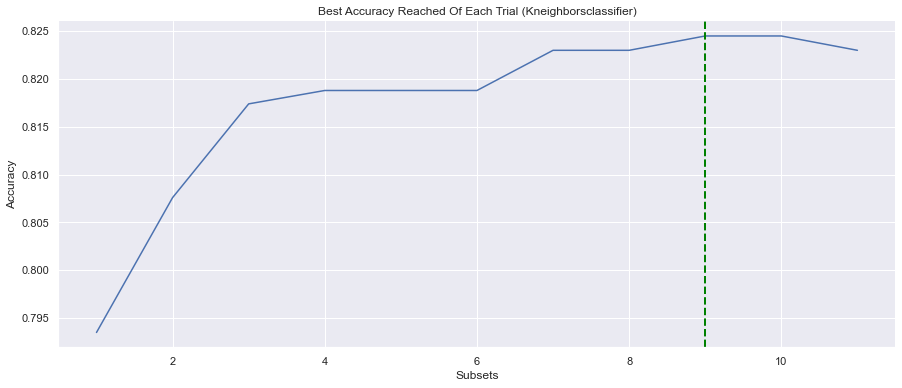

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Pclass', 'Embarked_title', 'Pclass_Fare_binned', 'Sex_title']
 
Best Accuracy: 
     0.8301
 
Total Time Spent: 37.97(s)


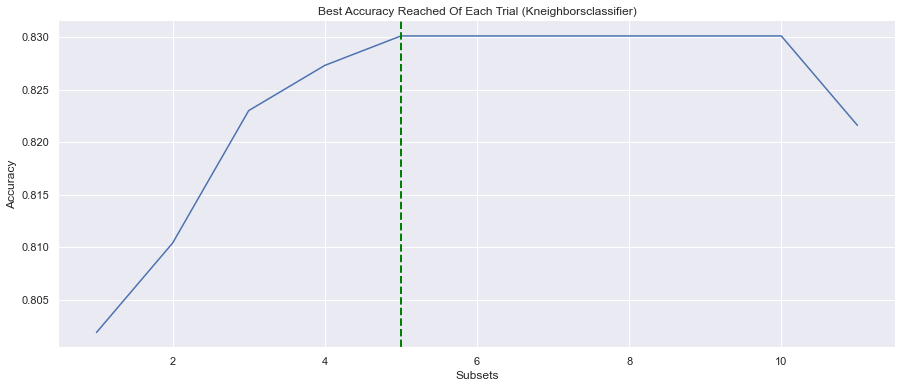

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Pclass', 'Embarked_Age_binned', 'title_Age_binned', 'title', 'Parch', 'FamilySize', 'Sex_Embarked', 'Pclass_IsAlone', 'Embarked']
 
Best Accuracy: 
     0.8399
 
Total Time Spent: 40.91(s)


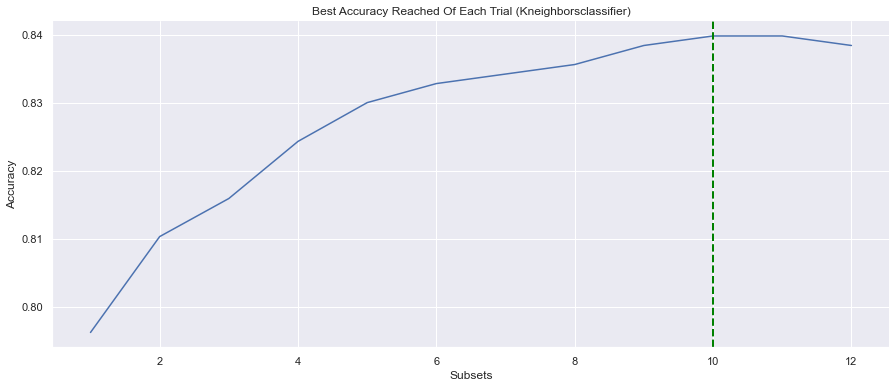

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Pclass', 'Embarked_Age_binned', 'title_Age_binned', 'Fare', 'Age_binned', 'Sex', 'Sex_Age_binned', 'title', 'Pclass', 'Embarked', 'Pclass_Age_binned']
 
Best Accuracy: 
     0.8469
 
Total Time Spent: 43.38(s)


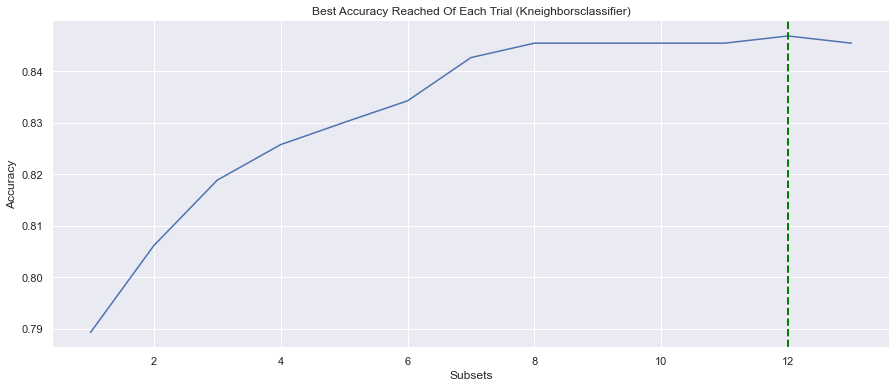

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Embarked_title', 'Sex_IsAlone', 'FamilySize', 'Sex_title']
 
Best Accuracy: 
     0.8286
 
Total Time Spent: 22.75(s)


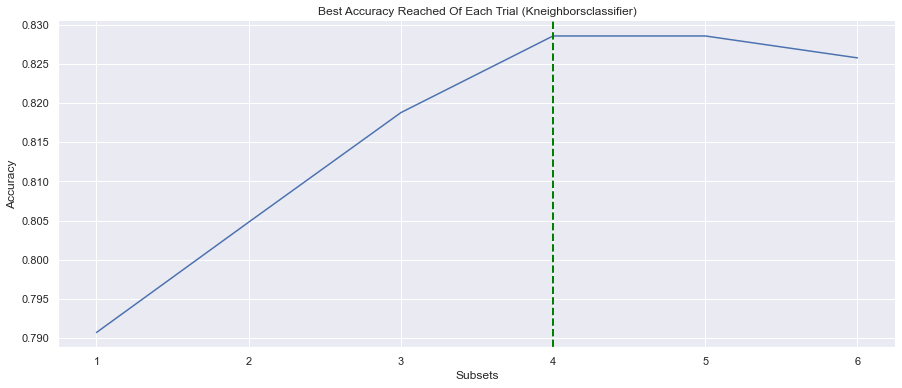

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Embarked', 'title_IsAlone', 'Embarked_Fare_binned', 'title', 'Embarked', 'Sex_Fare_binned', 'SibSp', 'Embarked_IsAlone', 'Pclass']
 
Best Accuracy: 
     0.8413
 
Total Time Spent: 38.14(s)


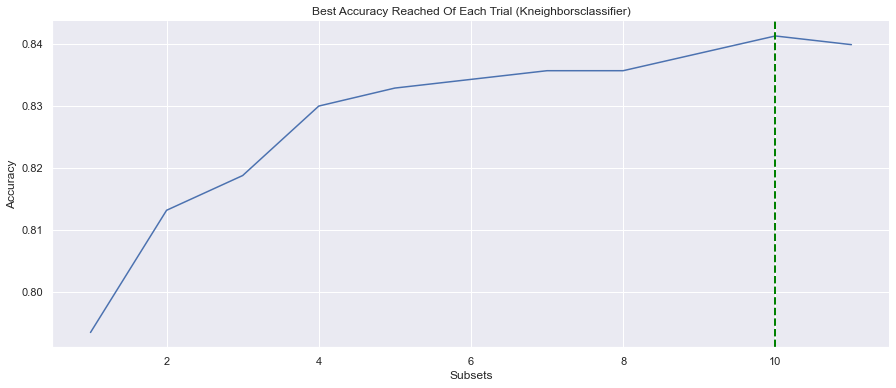

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Embarked', 'title']
 
Best Accuracy: 
     0.8315
 
Total Time Spent: 15.65(s)


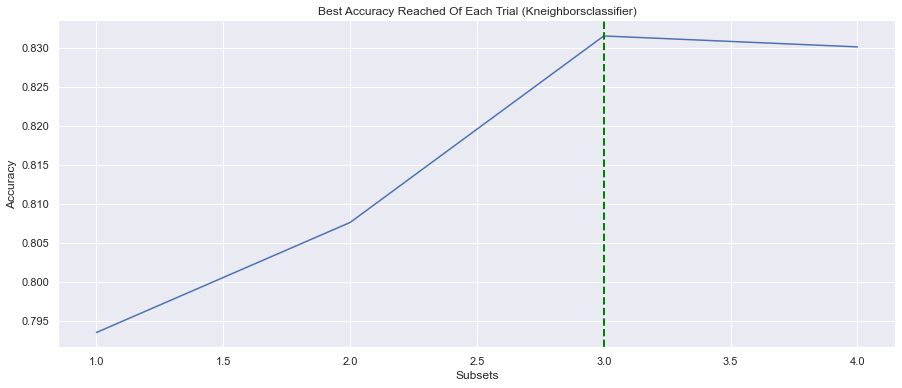

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Fare_binned', 'Embarked_Fare_binned', 'Sex', 'Pclass_Fare_binned', 'Pclass', 'Embarked', 'Sex_Embarked', 'Sex_Age_binned', 'Fare_binned', 'title', 'SibSp', 'Embarked_title', 'title_Age_binned']
 
Best Accuracy: 
     0.8315
 
Total Time Spent: 50.98(s)


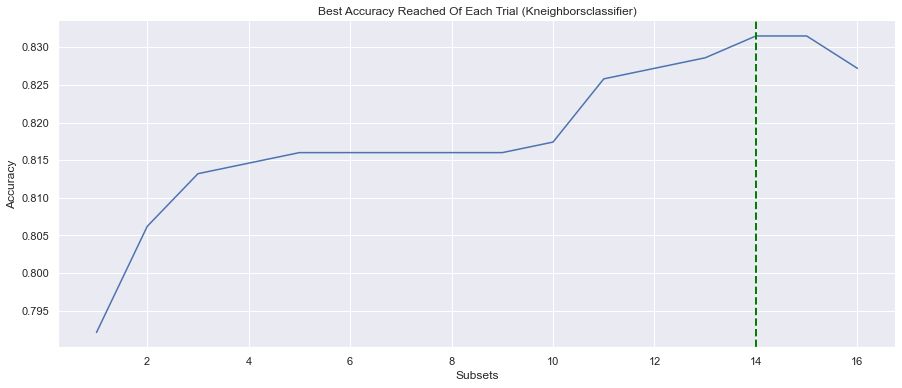

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex', 'Age_binned', 'title_IsAlone', 'FamilySize', 'Pclass_Age_binned', 'Sex_Age_binned', 'Fare', 'Sex_title']
 
Best Accuracy: 
     0.8356
 
Total Time Spent: 38.02(s)


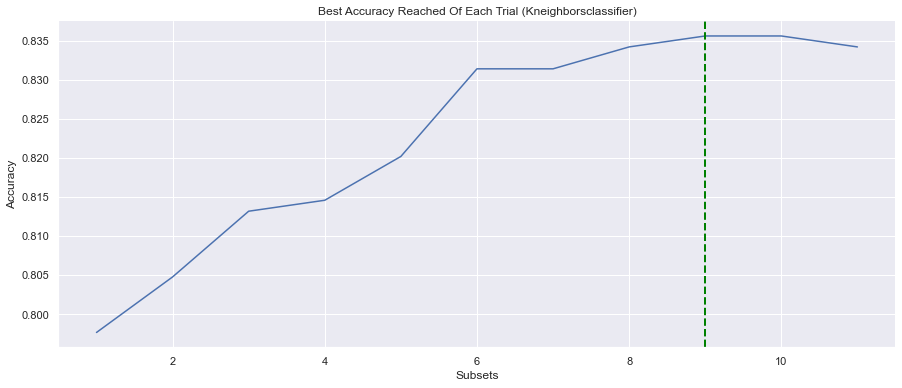

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Fare_binned', 'Embarked', 'title', 'Sex_title', 'SibSp', 'Age', 'Embarked_title', 'Embarked_Age_binned', 'Sex_Pclass', 'Sex_Embarked']
 
Best Accuracy: 
     0.8413
 
Total Time Spent: 43.46(s)


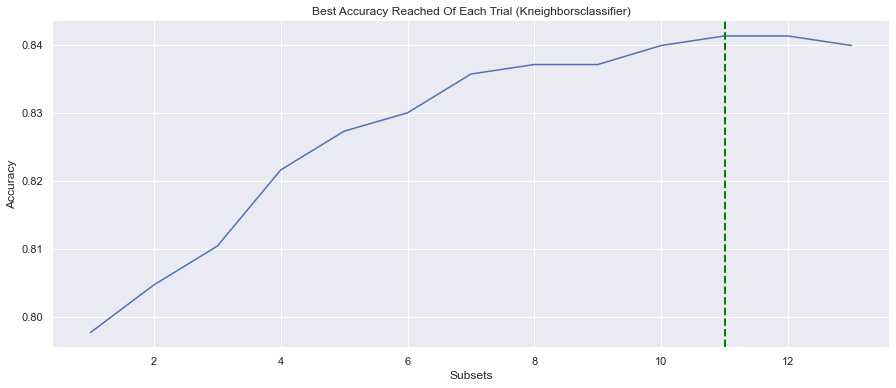

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex', 'Embarked', 'Age', 'title_Age_binned', 'Pclass_IsAlone', 'SibSp', 'Embarked_title', 'Embarked_Fare_binned']
 
Best Accuracy: 
     0.8385
 
Total Time Spent: 35.62(s)


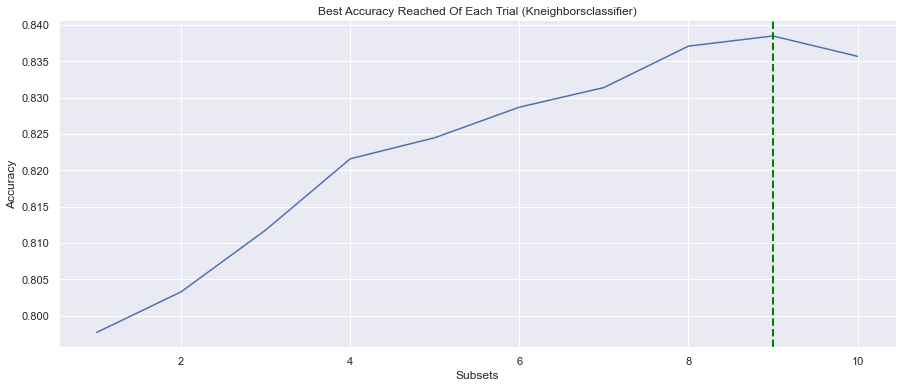

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex', 'Embarked_title', 'Age', 'Sex_title', 'SibSp', 'title', 'Fare']
 
Best Accuracy: 
     0.837
 
Total Time Spent: 32.86(s)


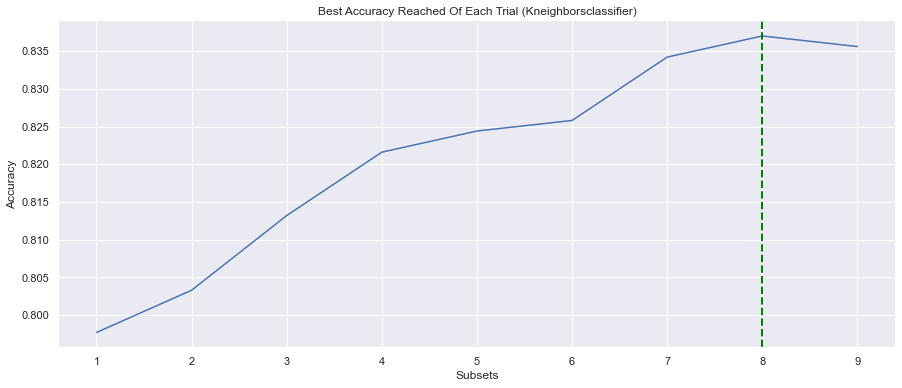

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex', 'Embarked_title', 'Age', 'title', 'SibSp', 'Parch', 'Embarked', 'Pclass_Fare_binned', 'Embarked_Fare_binned']
 
Best Accuracy: 
     0.8399
 
Total Time Spent: 38.67(s)


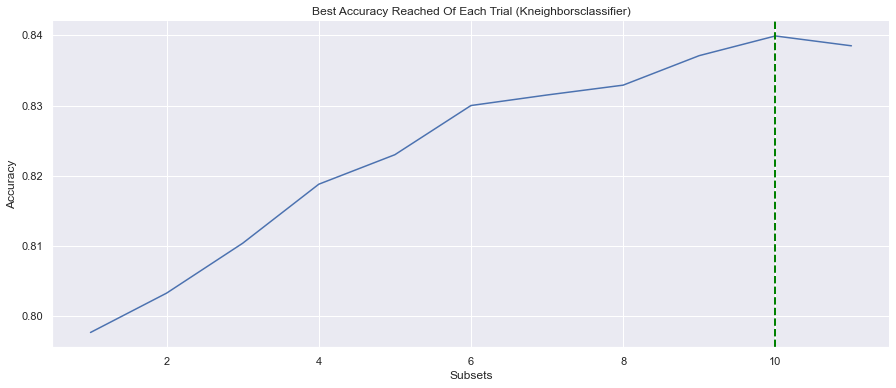

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_title', 'Embarked_title', 'Age', 'SibSp', 'Pclass_Fare_binned']
 
Best Accuracy: 
     0.8315
 
Total Time Spent: 26.4(s)


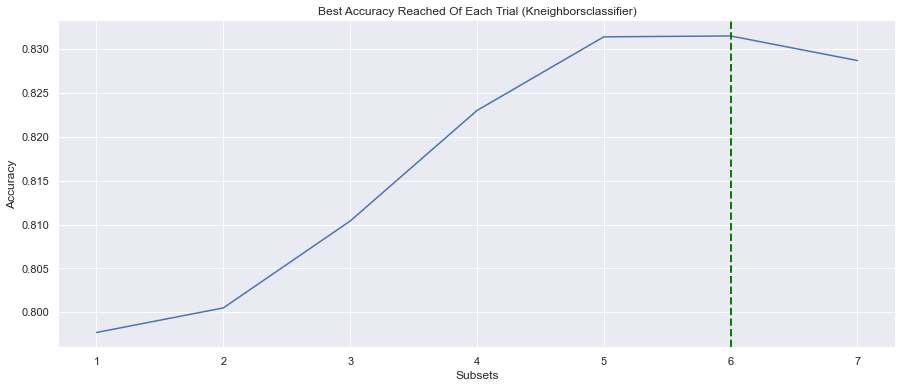

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_title', 'Embarked_title', 'Age', 'SibSp', 'Pclass_Fare_binned', 'Embarked']
 
Best Accuracy: 
     0.8315
 
Total Time Spent: 29.67(s)


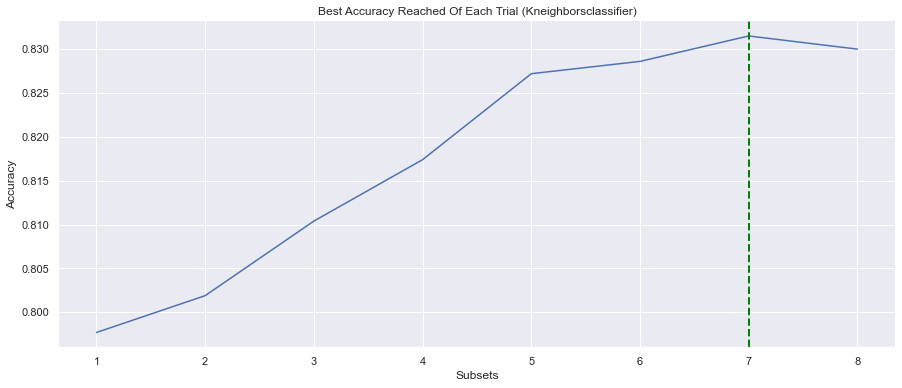

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Fare_binned', 'Embarked_title', 'Sex_IsAlone', 'Age', 'Pclass']
 
Best Accuracy: 
     0.823
 
Total Time Spent: 26.41(s)


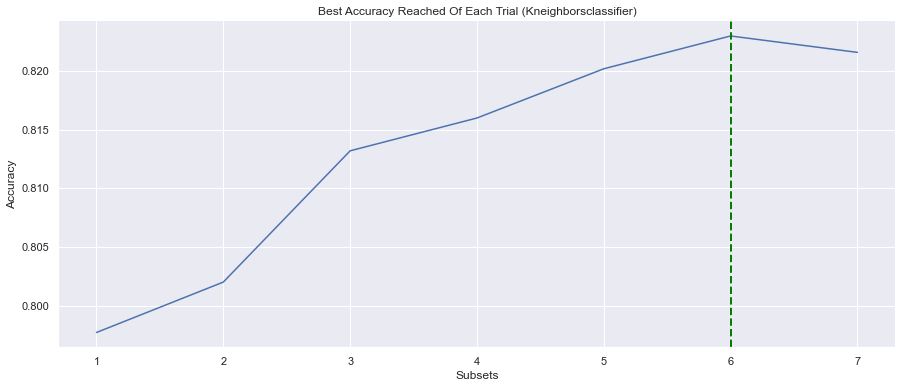

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_title', 'Embarked_Age_binned', 'title_Fare_binned', 'SibSp', 'Embarked_title']
 
Best Accuracy: 
     0.8385
 
Total Time Spent: 26.41(s)


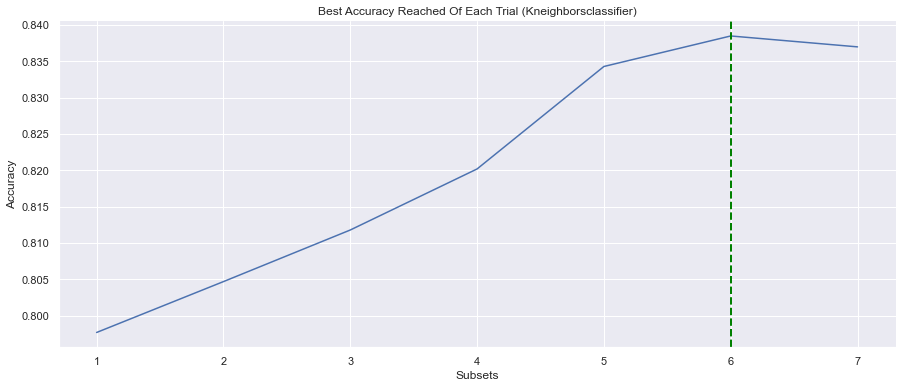

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_title', 'Embarked_Age_binned', 'Embarked_title', 'title_Age_binned', 'FamilySize']
 
Best Accuracy: 
     0.8272
 
Total Time Spent: 32.85(s)


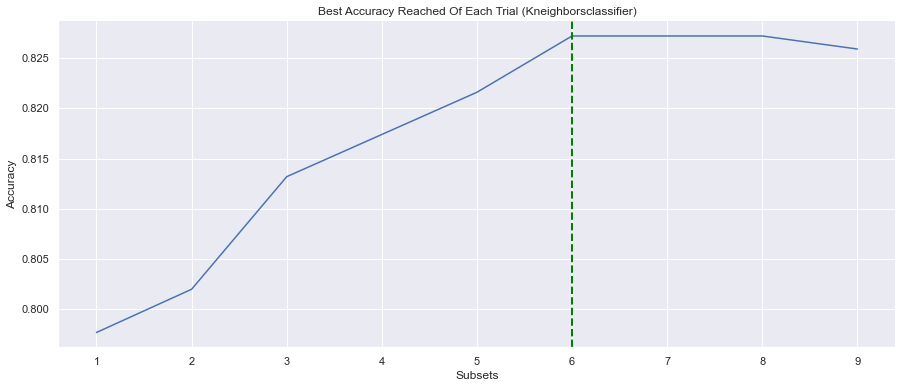

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'title_IsAlone', 'Pclass', 'Sex_Fare_binned', 'Embarked_Age_binned', 'Sex_IsAlone']
 
Best Accuracy: 
     0.8244
 
Total Time Spent: 26.39(s)


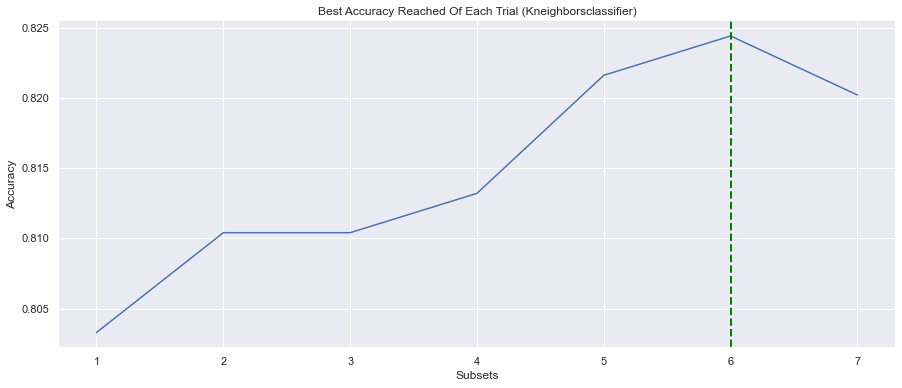

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Fare_binned', 'Embarked_Age_binned', 'title_IsAlone']
 
Best Accuracy: 
     0.8188
 
Total Time Spent: 19.51(s)


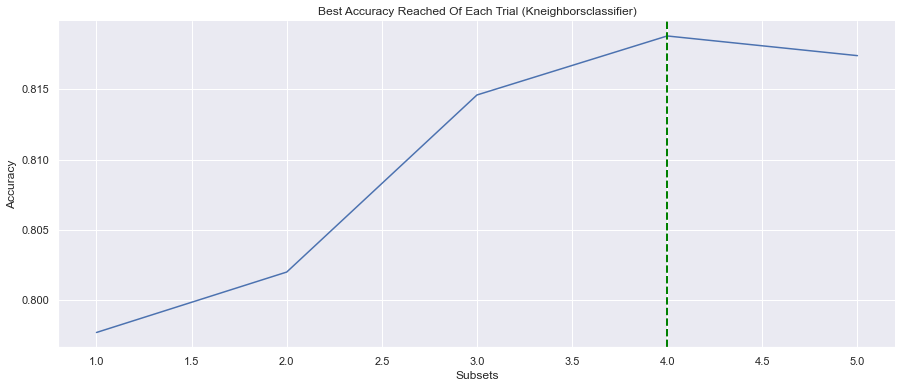

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex', 'Embarked_Age_binned', 'Pclass_IsAlone', 'Pclass', 'Sex_Pclass', 'Embarked', 'Pclass_Embarked', 'title', 'Fare_binned']
 
Best Accuracy: 
     0.8202
 
Total Time Spent: 41.76(s)


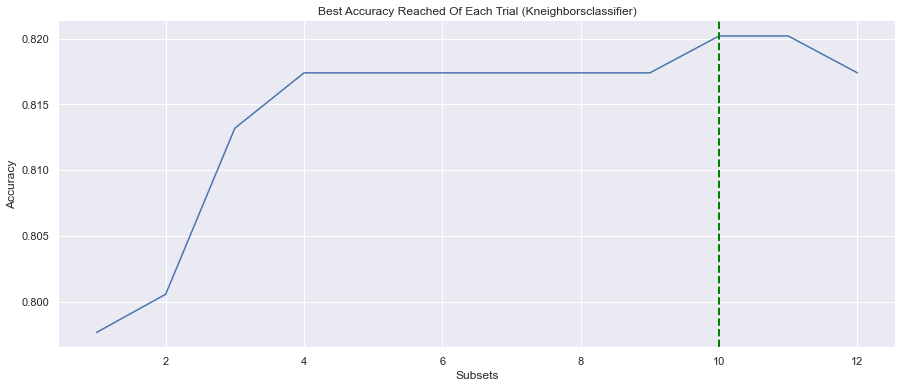

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex_Pclass', 'Sex_Embarked', 'Sex', 'Embarked', 'Pclass', 'title', 'Sex_title', 'Parch']
 
Best Accuracy: 
     0.8202
 
Total Time Spent: 32.8(s)


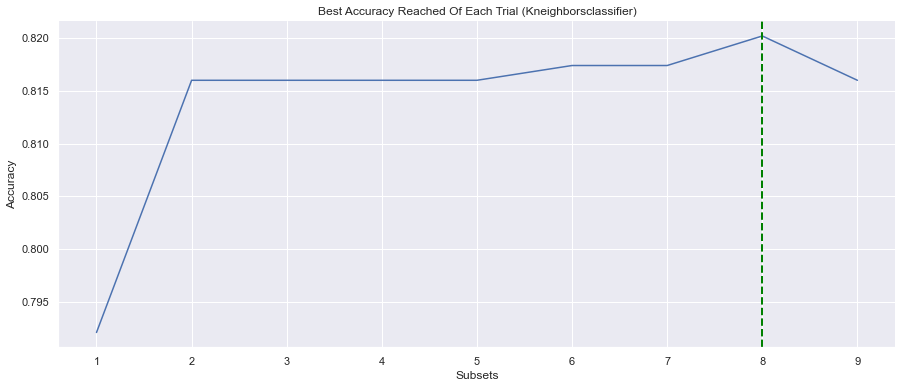

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex_title', 'Sex_Pclass', 'Embarked', 'Sex', 'Fare', 'Pclass_Fare_binned', 'Sex_Embarked', 'Pclass', 'Sex_Fare_binned', 'Embarked_title']
 
Best Accuracy: 
     0.8202
 
Total Time Spent: 44.02(s)


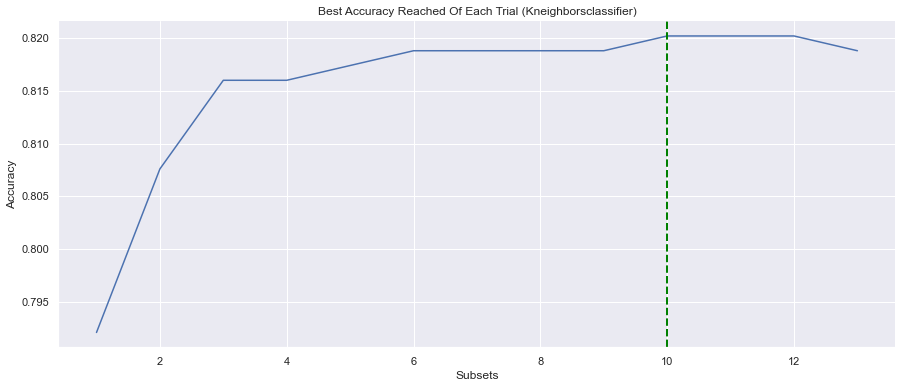

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex_Pclass', 'Sex_Embarked', 'Sex', 'Embarked', 'Pclass', 'title', 'title_Fare_binned', 'SibSp', 'Pclass_Embarked', 'Age', 'Fare']
 
Best Accuracy: 
     0.8258
 
Total Time Spent: 41.1(s)


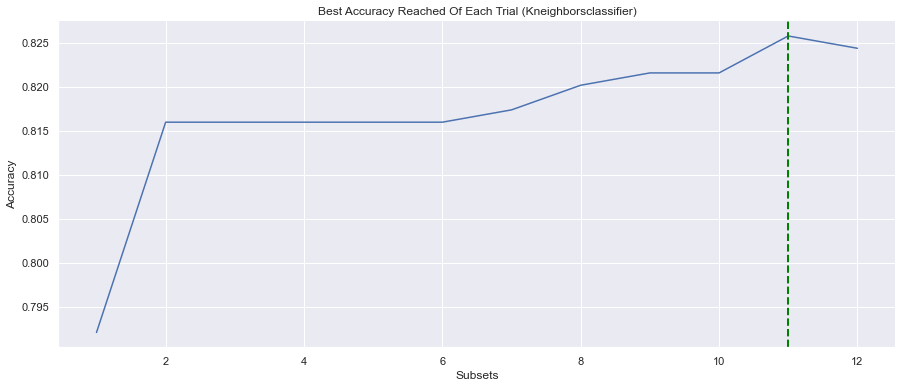

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'title_IsAlone', 'Sex_Pclass', 'IsAlone']
 
Best Accuracy: 
     0.816
 
Total Time Spent: 19.37(s)


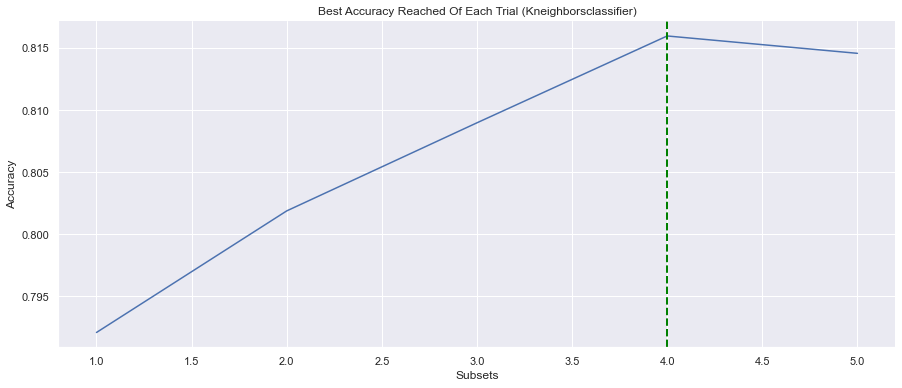

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------
 
Searching the best subset of features with KNeighborsClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex_Pclass', 'Sex_Embarked', 'Sex', 'Embarked', 'Pclass', 'title', 'title_Fare_binned', 'SibSp']
 
Best Accuracy: 
     0.8202
 
Total Time Spent: 32.4(s)


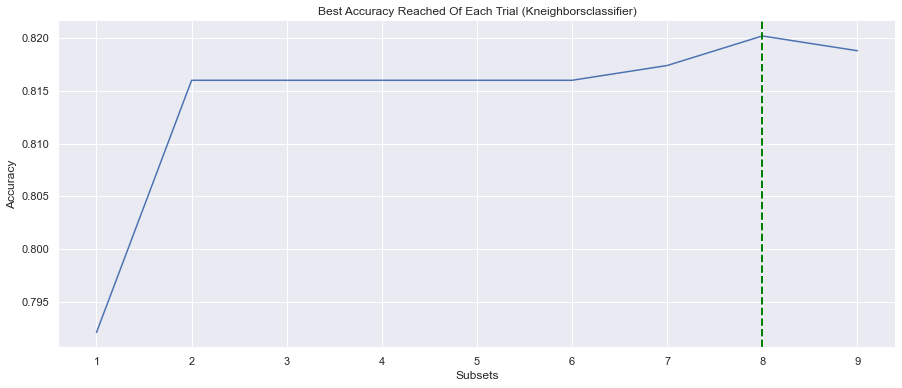

--------------------------------End of Recursive Features Selection (KNeighborsClassifier)-------------------------------


In [612]:
from sklearn.neighbors import KNeighborsClassifier
for k in range(2, len(X_train.columns) + 1):
    knn = KNeighborsClassifier(n_neighbors=k, 
                                   weights='uniform',
                                   algorithm='auto',
                                   leaf_size=30, 
                                   p=2, 
                                   metric='minkowski',
                                   metric_params=None,
                                   n_jobs=8)

    rfs = RecursiveFeatureSelector()
    rfs.trial(estimators=knn, 
               X=X_train, 
               y=y_train, 
               cv=5, 
               scoring='accuracy', 
               max_round=None, 
               fail_tolerance=1, 
               least_gain=None,
               start_from=None,
               pool=[[]],
               n_digit=4, 
               verbose=2)

#### Best subset for knn: ['Pclass_title', 'Sex_Pclass', 'Embarked_Age_binned', 'title_Age_binned', 'Fare', 'Age_binned', 'Sex', 'Sex_Age_binned', 'title', 'Pclass', 'Embarked', 'Pclass_Age_binned'] 
#### best k for knn: 10

In [614]:
search_space_knn={'n_neighbors':[10], 
                  'weights':['uniform', 'distance'], 
                  'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
                  'leaf_size':np.linspace(1, 10, 10), 
                  'p':[1, 2], 
                  'metric':['minkowski'],
                  'n_jobs':[8]}
    
hyperParameterTuning(knn, X_train[rfs.best_subsets['KNeighborsClassifier']], y_train, search_space_knn)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
algorithm='ball_tree',
leaf_size=1.0,
metric='minkowski',
n_jobs=8,
n_neighbors=10,
p=1,
weights='uniform',


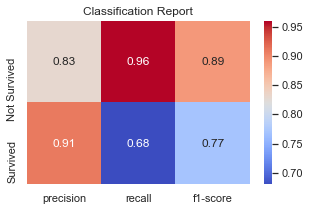

Cross Validated Accuracy: 0.85


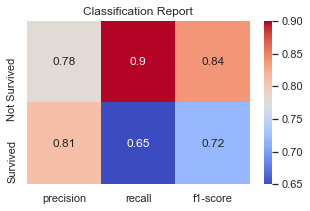

Cross Validated Accuracy: 0.79


In [156]:
knn = KNeighborsClassifier(n_neighbors=10, 
                               weights='uniform',
                               algorithm='ball_tree',
                               leaf_size=1, 
                               p=1, 
                               metric='minkowski',
                               metric_params=None,
                               n_jobs=8)

knn.fit(X_train[rfs.best_subsets['KNeighborsClassifier']], y_train)
plot_cr(knn, X_train[rfs.best_subsets['KNeighborsClassifier']], y_train, ['Not Survived', 'Survived'])
plot_cr(knn, X_val[rfs.best_subsets['KNeighborsClassifier']], y_val, ['Not Survived', 'Survived'])

 
Searching the best subset of features with SVC...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex_title', 'FamilySize', 'Age_binned']
 
Best Accuracy: 
     0.8328
 
Total Time Spent: 2.93(s)


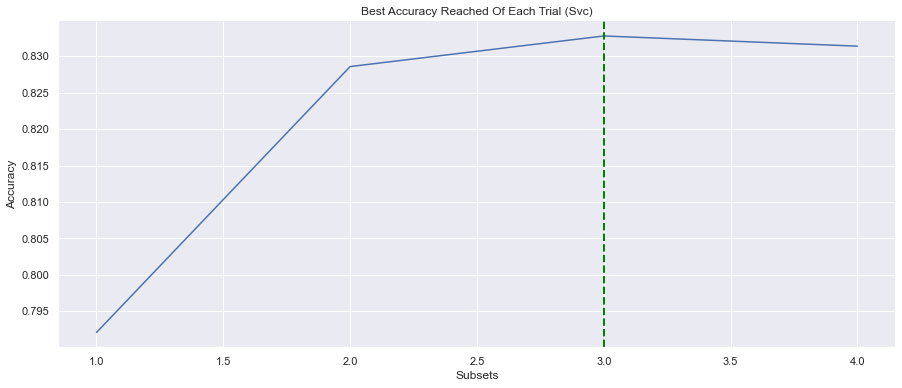

--------------------------------End of Recursive Features Selection (SVC)-------------------------------


In [618]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')

rfs = RecursiveFeatureSelector()
rfs.trial(estimators=svc, 
           X=X_train, 
           y=y_train, 
           cv=5, 
           scoring='accuracy', 
           max_round=None, 
           fail_tolerance=1, 
           least_gain=None,
           start_from=None,
           pool=[[]],
           n_digit=4, 
           verbose=2)

#### Best subset for svc: 
['Sex_title', 'FamilySize', 'Age_binned']

In [619]:
search_space_svc={'C':np.linspace(0.0001, 1, 10), 
                  'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
                  'degree':[1, 2, 3, 4], 
                  'gamma':['scale', 'auto'], 
                  'shrinking':[True, False], 
                  'tol':[0.0001, 0.001, 0.01, 0.1],
                  'class_weight':['balanced', None]}
    
hyperParameterTuning(svc, X_train[rfs.best_subsets['SVC']], y_train, search_space_svc)

Fitting 5 folds for each of 5120 candidates, totalling 25600 fits
C=0.6667000000000001,
class_weight=None,
degree=1,
gamma='scale',
kernel='rbf',
shrinking=True,
tol=0.0001,


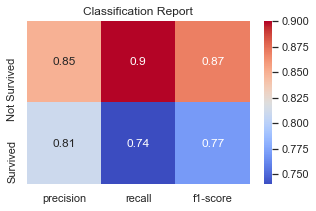

Cross Validated Accuracy: 0.84


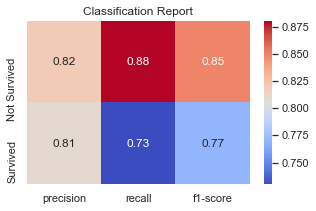

Cross Validated Accuracy: 0.82


In [160]:
svc = SVC(C=0.6667000000000001,
class_weight=None,
degree=1,
gamma='scale',
kernel='rbf',
shrinking=True,
tol=0.0001)

svc.fit(X_train[rfs.best_subsets['SVC']], y_train)
plot_cr(svc, X_train[rfs.best_subsets['SVC']], y_train, ['Not Survived', 'Survived'])
plot_cr(svc, X_val[rfs.best_subsets['SVC']], y_val, ['Not Survived', 'Survived'])

 
Searching the best subset of features with DecisionTreeClassifier...
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'SibSp', 'Embarked_title', 'Sex_title', 'title', 'Pclass']
 
Best Accuracy: 
     0.8301
 
Total Time Spent: 3.09(s)


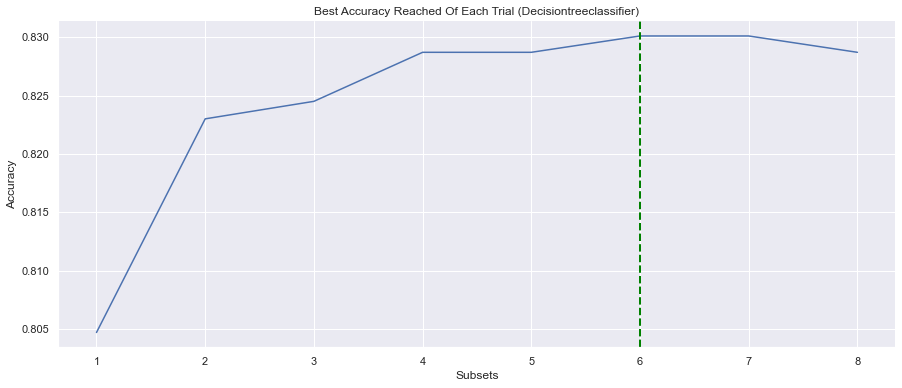

--------------------------------End of Recursive Features Selection (DecisionTreeClassifier)-------------------------------


In [623]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)

rfs = RecursiveFeatureSelector()
rfs.trial(estimators=dtc, 
           X=X_train, 
           y=y_train, 
           cv=5, 
           scoring='accuracy', 
           max_round=None, 
           fail_tolerance=1, 
           least_gain=None,
           start_from=None,
           pool=[[]],
           n_digit=4, 
           verbose=2)

### best subset for DecisionTreeClassifier: 
['Pclass_title', 'SibSp', 'Embarked_title', 'Sex_title', 'title', 'Pclass']

In [624]:
search_space_dtc={'criterion':['gini', 'entropy'], 
                  'splitter':['best', 'random'], 
                  'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                  'min_samples_split':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                  'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                  'max_features':['auto', 'sqrt', 'log2', None],
                  'class_weight':['balanced', None]}
    
hyperParameterTuning(dtc, X_train[rfs.best_subsets['DecisionTreeClassifier']], y_train, search_space_dtc)

Fitting 5 folds for each of 32000 candidates, totalling 160000 fits
class_weight=None,
criterion='gini',
max_depth=6,
max_features=None,
min_samples_leaf=4,
min_samples_split=2,
splitter='best',


F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.7120654  ... 0.81743327 0.83426573 0.81743327]
  category=UserWarning


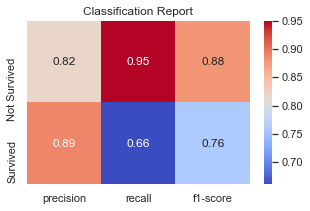

Cross Validated Accuracy: 0.84


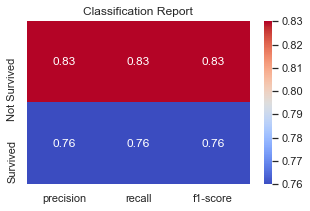

Cross Validated Accuracy: 0.80


In [163]:
dtc = DecisionTreeClassifier(class_weight=None,
criterion='gini',
max_depth=5,
max_features=None,
min_samples_leaf=1,
min_samples_split=2,
splitter='best')

dtc.fit(X_train[rfs.best_subsets['DecisionTreeClassifier']], y_train)
plot_cr(dtc, X_train[rfs.best_subsets['DecisionTreeClassifier']], y_train, ['Not Survived', 'Survived'])
plot_cr(dtc, X_val[rfs.best_subsets['DecisionTreeClassifier']], y_val, ['Not Survived', 'Survived'])

 
Searching the best subset of features with RandomForestClassifier...
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
Failed to improve Accuracy.
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex_Pclass', 'Embarked', 'SibSp', 'Age', 'title', 'Pclass_Embarked', 'Pclass_title', 'Parch', 'title_Age_binned', 'Fare_binned', 'Embarked_Age_binned', 'Pclass', 'Embarked_title', 'Sex_title', 'Pclass_Age_binned', 'Pclass_Fare_binned', 'FamilySize', 'Embarked_Fare_binned', 'Pclass_IsAlone', 'Sex_Embarked', 'Embarked_IsAlone', 'Fare', 'IsAlone', 'Age_binned', 'Sex_Fare_binned', 'Age

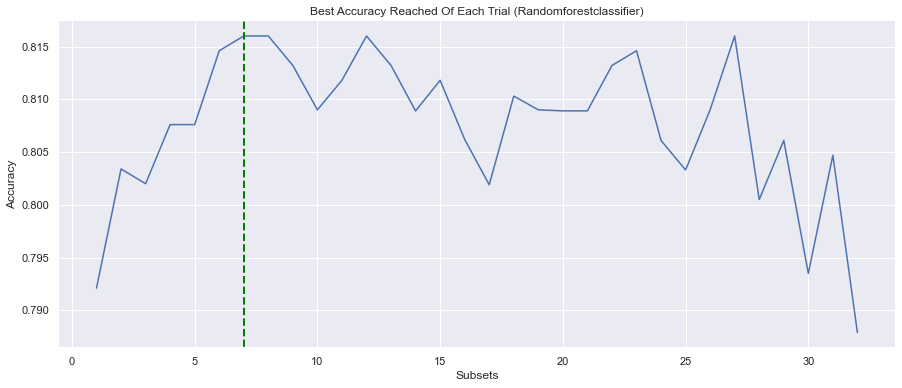

--------------------------------End of Recursive Features Selection (RandomForestClassifier)-------------------------------


In [630]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(max_depth=2, random_state=0)

rfs = RecursiveFeatureSelector()
rfs.trial(estimators=rfc, 
           X=X_train, 
           y=y_train, 
           cv=5, 
           scoring='accuracy', 
           max_round=None, 
           fail_tolerance=33, 
           least_gain=None,
           start_from=None,
           pool=[[]],
           n_digit=4, 
           verbose=2)

#### best subset for RandomForestClassifier: 
['Sex_Pclass', 'Embarked', 'SibSp', 'Age', 'title', 'Pclass_Embarked', 'Pclass_title', 'Parch', 'title_Age_binned', 'Fare_binned', 'Embarked_Age_binned', 'Pclass', 'Embarked_title', 'Sex_title', 'Pclass_Age_binned', 'Pclass_Fare_binned', 'FamilySize', 'Embarked_Fare_binned', 'Pclass_IsAlone', 'Sex_Embarked', 'Embarked_IsAlone', 'Fare', 'IsAlone', 'Age_binned', 'Sex_Fare_binned', 'Age_binned_Fare_binned', 'title_Fare_binned']

In [632]:
search_space_rfc={'criterion':['gini', 'entropy'], 
                  #'splitter':['best', 'random'], 
                  'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                  'min_samples_split':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                  'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                  'max_features':['auto', 'sqrt', 'log2', None],
                  'class_weight':['balanced', None]}
    
hyperParameterTuning(rfc, X_train[rfs.best_subsets['RandomForestClassifier']], y_train, search_space_rfc)

Fitting 5 folds for each of 16000 candidates, totalling 80000 fits
class_weight=None,
criterion='entropy',
max_depth=10,
max_features='auto',
min_samples_leaf=4,
min_samples_split=10,


F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.79209101 0.79209101 ... 0.82999114 0.82999114 0.82999114]
  category=UserWarning


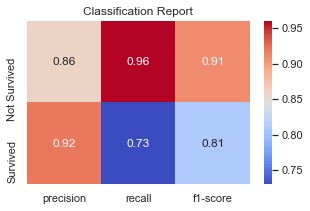

Cross Validated Accuracy: 0.88


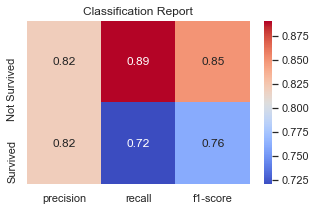

Cross Validated Accuracy: 0.82


In [166]:
rfc = RandomForestClassifier(class_weight=None,
criterion='entropy',
max_depth=10,
max_features='auto',
min_samples_leaf=4,
min_samples_split=10)

rfc.fit(X_train[rfs.best_subsets['RandomForestClassifier']], y_train)
plot_cr(rfc, X_train[rfs.best_subsets['RandomForestClassifier']], y_train, ['Not Survived', 'Survived'])
plot_cr(rfc, X_val[rfs.best_subsets['RandomForestClassifier']], y_val, ['Not Survived', 'Survived'])

 
Searching the best subset of features with LinearDiscriminantAnalysis...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Sex', 'SibSp', 'IsAlone', 'Age', 'Parch', 'Pclass', 'Age_binned', 'Fare', 'title_IsAlone', 'title', 'Fare_binned', 'Embarked', 'FamilySize', 'Sex_Pclass', 'Sex_Embarked', 'Sex_title']
 
Best Accuracy: 
     0.8371
 
Total Time Spent: 7.36(s)


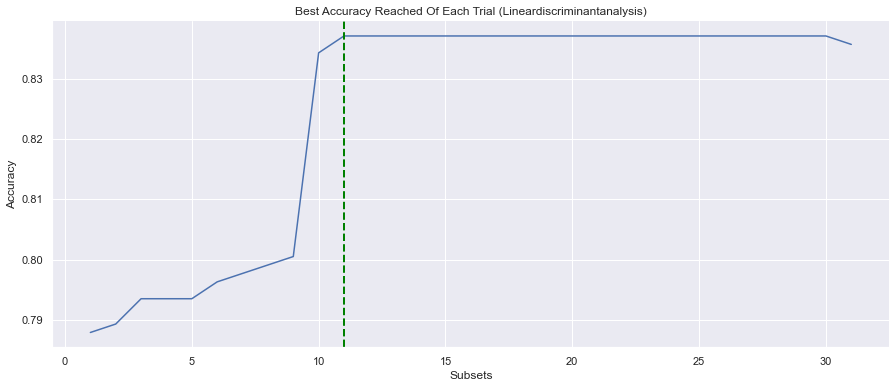

--------------------------------End of Recursive Features Selection (LinearDiscriminantAnalysis)-------------------------------


In [636]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

rfs = RecursiveFeatureSelector()
rfs.trial(estimators=lda, 
           X=X_train, 
           y=y_train, 
           cv=5, 
           scoring='accuracy', 
           max_round=None, 
           fail_tolerance=1, 
           least_gain=None,
           start_from=None,
           pool=[[]],
           n_digit=4, 
           verbose=2)

#### best subset for lda: 
['Sex', 'SibSp', 'IsAlone', 'Age', 'Parch', 'Pclass', 'Age_binned', 'Fare', 'title_IsAlone', 'title', 'Fare_binned', 'Embarked', 'FamilySize', 'Sex_Pclass', 'Sex_Embarked', 'Sex_title']

In [637]:
search_space_lda={'solver':['svd', 'lsqr', 'eigen'], 
                  'shrinkage':['auto', 1, 0.1, 0.01, 0.001], 
                  'n_components':np.linspace(1, len(X_train)-1), 
                  'tol':[0.0001, 0.001, 0.01, 0.1]}
    
hyperParameterTuning(lda, X_train[rfs.best_subsets['LinearDiscriminantAnalysis']], y_train, search_space_lda)

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits
n_components=1.0,
shrinkage=0.001,
solver='lsqr',
tol=0.0001,


F:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  category=UserWarning


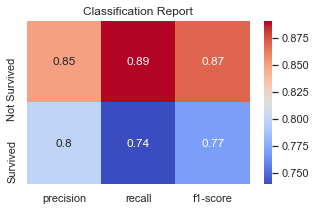

Cross Validated Accuracy: 0.83


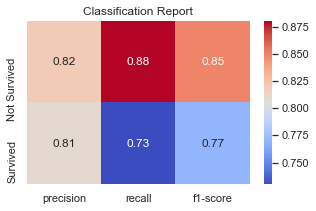

Cross Validated Accuracy: 0.82


In [170]:
lda = LinearDiscriminantAnalysis(n_components=1.0,
shrinkage=0.001,
solver='lsqr',
tol=0.0001)

lda.fit(X_train[rfs.best_subsets['LinearDiscriminantAnalysis']], y_train)
plot_cr(lda, X_train[rfs.best_subsets['LinearDiscriminantAnalysis']], y_train, ['Not Survived', 'Survived'])
plot_cr(lda, X_val[rfs.best_subsets['LinearDiscriminantAnalysis']], y_val, ['Not Survived', 'Survived'])

 
Searching the best subset of features with AdaBoostClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'Sex_Embarked', 'Parch', 'Embarked_title', 'SibSp', 'Age_binned', 'Pclass_IsAlone']
 
Best Accuracy: 
     0.8399
 
Total Time Spent: 42.5(s)


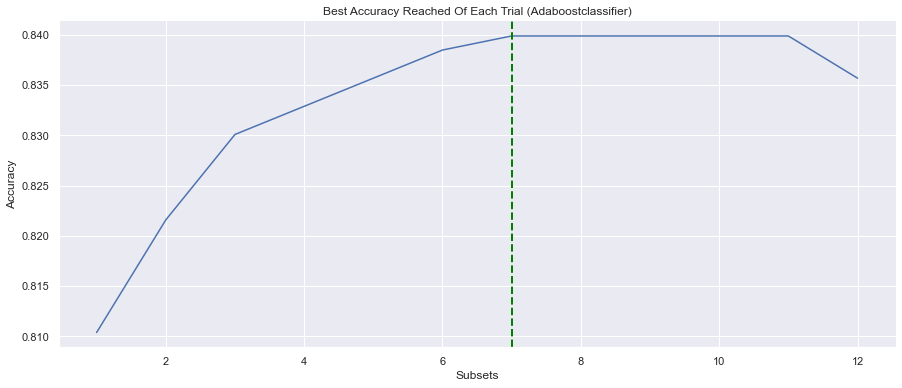

--------------------------------End of Recursive Features Selection (AdaBoostClassifier)-------------------------------


In [640]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100, random_state=0)

rfs = RecursiveFeatureSelector()
rfs.trial(estimators=ada, 
           X=X_train, 
           y=y_train, 
           cv=5, 
           scoring='accuracy', 
           max_round=None, 
           fail_tolerance=1, 
           least_gain=None,
           start_from=None,
           pool=[[]],
           n_digit=4, 
           verbose=2)

#### best subset for ada: ['Pclass_title', 'Sex_Embarked', 'Parch', 'Embarked_title', 'SibSp', 'Age_binned', 'Pclass_IsAlone']

In [641]:
search_space_ada={'n_estimators':[1, 50, 100, 150, 200, 500], 
                  'learning_rate':[0.1, 0.01, 0.001, 0.0001], 
                  'algorithm':['SAMME', 'SAMME.R']}
    
hyperParameterTuning(ada, X_train[rfs.best_subsets['AdaBoostClassifier']], y_train, search_space_ada)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
algorithm='SAMME.R',
learning_rate=0.1,
n_estimators=500,


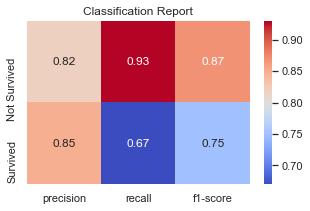

Cross Validated Accuracy: 0.83


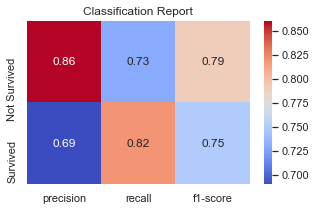

Cross Validated Accuracy: 0.77


In [172]:
ada = AdaBoostClassifier(algorithm='SAMME.R',
learning_rate=0.1,
n_estimators=500)

ada.fit(X_train[rfs.best_subsets['AdaBoostClassifier']], y_train)
plot_cr(ada, X_train[rfs.best_subsets['AdaBoostClassifier']], y_train, ['Not Survived', 'Survived'])
plot_cr(ada, X_val[rfs.best_subsets['AdaBoostClassifier']], y_val, ['Not Survived', 'Survived'])

 
Searching the best subset of features with XGBClassifier...
--------------------------------------------------------Trial Summary--------------------------------------------------------
Best Subset Found: 
     ['Pclass_title', 'FamilySize', 'Sex_IsAlone']
 
Best Accuracy: 
     0.8314
 
Total Time Spent: 28.96(s)


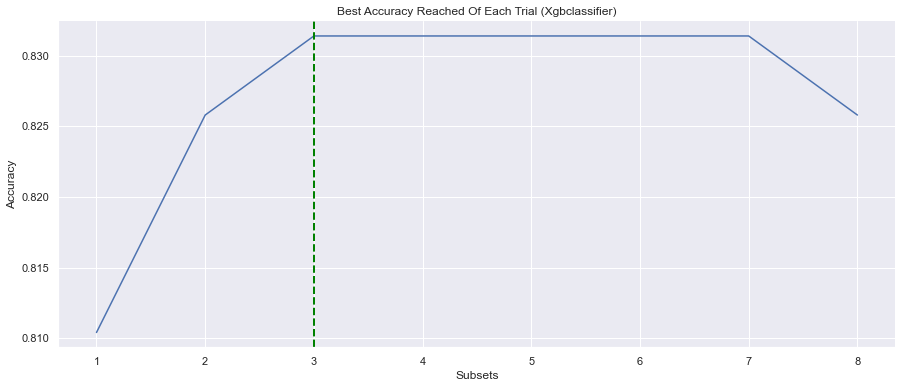

--------------------------------End of Recursive Features Selection (XGBClassifier)-------------------------------


In [643]:
import xgboost as xgb
xgbc = xgb.XGBClassifier(verbosity=0, use_label_encoder=False)

rfs = RecursiveFeatureSelector()
rfs.trial(estimators=xgbc, 
           X=X_train, 
           y=y_train, 
           cv=5, 
           scoring='accuracy', 
           max_round=None, 
           fail_tolerance=1, 
           least_gain=None,
           start_from=None,
           pool=[[]],
           n_digit=4, 
           verbose=2)

['Pclass_title', 'FamilySize', 'Sex_IsAlone']

In [644]:
search_space_xgbc = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

hyperParameterTuning(xgbc, X_train[rfs.best_subsets['XGBClassifier']], y_train, search_space_xgbc)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
colsample_bytree=0.7,
learning_rate=0.01,
max_depth=7,
min_child_weight=5,
n_estimators=200,
objective='reg:squarederror',
subsample=0.7,


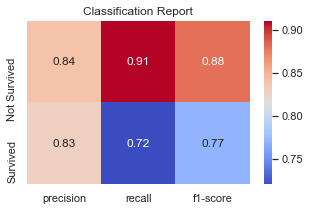

Cross Validated Accuracy: 0.84


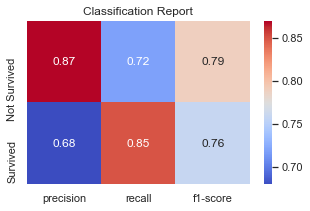

Cross Validated Accuracy: 0.78


In [176]:
xgbc = xgb.XGBClassifier(
colsample_bytree=0.7,
learning_rate=0.01,
max_depth=7,
min_child_weight=5,
n_estimators=200,
objective='reg:squarederror',
subsample=0.7,
use_label_encoder=False)

xgbc.fit(X_train[rfs.best_subsets['XGBClassifier']], y_train)
plot_cr(xgbc, X_train[rfs.best_subsets['XGBClassifier']], y_train, ['Not Survived', 'Survived'])
plot_cr(xgbc, X_val[rfs.best_subsets['XGBClassifier']], y_val, ['Not Survived', 'Survived'])

In [59]:
kf_res={'lr': 0.8104, 'knn': 0.8469, 'svc': 0.8328, 'dtc': 0.8301, 'rfc': 0.816, 'lda': 0.8371, 'ada': 0.8399, 'xgbc': 0.8314}
tuned_res={'lr': 0.78, 'knn': 0.82, 'svc': 0.82, 'dtc': 0.82, 'rfc': 0.83, 'lda': 0.82, 'ada': 0.77, 'xgbc': 0.78}
result = pd.DataFrame([kf_res, tuned_res], index=['cross validation acc', 'tuned acc']).T.sort_values('tuned acc', ascending=False)
result

,cross validation acc,tuned acc
rfc,0.8160,0.83
knn,0.8469,0.82
svc,0.8328,0.82
dtc,0.8301,0.82
lda,0.8371,0.82
lr,0.8104,0.78
xgbc,0.8314,0.78
ada,0.8399,0.77
